# Abstrakt

Celem tej analizy było opracowanie modeli predykcyjnych mających na celu przewidywanie anulowania rezerwacji hotelowych. Wykorzystano pięć różnych algorytmów uczenia maszynowego: 

- `regresję logistyczną` 
- `drzewa decyzyjne`
- `lasy losowe` 
- `k najbliższych sąsiadów (k-NN)`
- `gradient boosting` 

Modele klasyfikacji zostały użyte, ponieważ zadanie polegało na przewidywaniu kategorycznego wyniku: czy rezerwacja zostanie anulowana, czy nie. Modele te radzą sobie ze złożonymi relacjami między cechami i dobrze nadają się do klasyfikacji binarnej.

Dane dotyczące rezerwacji hotelowych poddano wstępnej obróbce oraz selekcji cech na podstawie ich ważności.

Początkowe modele przeszły proces optymalizacji hiperparametrów przy użyciu Grid Search z walidacją krzyżową, co pozwoliło na znalezienie najlepszych parametrów dla każdego z algorytmów. Modele zostały ocenione na zbiorze testowym, a wyniki zostały porównane pod względem kilku kluczowych metryk: 

- `dokładności (Accuracy)`
- `precyzji (Precision)` 
- `czułości (Recall)`
- `miary F1 (F1 Score)`
- `pola pod krzywą ROC (ROC AUC)`

Spośród wszystkich rozważanych modeli, najlepsze wyniki osiągnął model lasów losowych, uzyskując najwyższe wartości dla metryk Accuracy (88.81%), Precision (86.32%), F1 Score (82.44%) oraz ROC AUC (94.67%). Model gradient boosting również wykazał się wysoką skutecznością, osiągając podobne wyniki. Modele k-NN oraz drzewa decyzyjne uzyskały nieco niższe wyniki, jednak nadal były one satysfakcjonujące i przewyższały regresję logistyczną.

Na podstawie wyników analizy, **model lasów losowych został uznany za najbardziej odpowiedni do przewidywania anulowania rezerwacji hotelowych**. Model ten może być z powodzeniem zastosowany w praktyce do wspomagania decyzji biznesowych w branży hotelarskiej, takich jak zarządzanie zasobami, optymalizacja przychodów oraz planowanie budżetu.


# Wstępna analiza danych

## Załadowanie bibliotek

In [50]:
# Przetwarzanie danych
import numpy as np
import pandas as pd

# Wizualizacje
import matplotlib.pyplot as plt
import seaborn as sns

#


# Uczenie maszynowe
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, 
    confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
)
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Obsługa błędów
import warnings



## Załadowanie danych

In [ ]:
data = pd.read_csv('Hotel Reservations.csv', sep = ',')
#data

## Struktura Danych
Dane są kompletnie wypełnione (brak wartości null) dla wszystkich kolumn, co jest korzystne dla procesu modelowania.

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

In [66]:
print(data.describe())


       no_of_adults  no_of_children  no_of_weekend_nights  no_of_week_nights  \
count  36275.000000    36275.000000          36275.000000       36275.000000   
mean       1.844962        0.105279              0.810724           2.204300   
std        0.518715        0.402648              0.870644           1.410905   
min        0.000000        0.000000              0.000000           0.000000   
25%        2.000000        0.000000              0.000000           1.000000   
50%        2.000000        0.000000              1.000000           2.000000   
75%        2.000000        0.000000              2.000000           3.000000   
max        4.000000       10.000000              7.000000          17.000000   

       required_car_parking_space     lead_time  arrival_year  arrival_month  \
count                36275.000000  36275.000000  36275.000000   36275.000000   
mean                     0.030986     85.232557   2017.820427       7.423653   
std                      0.173281     8

## Analiza zmiennych numerycznych

`Liczba dorosłych`

Większość rezerwacji obejmuje dwóch dorosłych, co sugeruje, że pokoje te często są rezerwowane przez pary. Rezerwacje dla jednej lub trzech osób dorosłych występują rzadziej.

`Liczba dzieci`

Rezerwacje najczęścij obejmują wyłącznie dorosłych lub pary bez dzieci. Rezerwacje z jednym lub dwoma dziećmi są rzadsze, ale nadal znaczące.

`Liczba nocy weekendowych`

Histogram wskazuje, że większość rezerwacji obejmuje weekend.

`Liczba nocy w tygodniu`

Najczęściej rezerwacje obejmują od jednej do trzech nocy w tygodniu. Dłuższe rezerwacje, obejmujące do pięciu nocy są mniej typowe.

`Czas oczekiwania`

Większość rezerwacji dokonywana jest z niewielkim wyprzedzeniem, najczęściej w ciągu kilkudziesięciu dni przed planowanym pobytem. Dłuższe okresy są rzadsze.

`Liczba wcześniejszych anulacji`

Większość gości nie ma historii wcześniejszych anulacji.

`Liczba wcześniejszych rezerwacji nieanulowanych`

Podobnie jak w przypadku anulacji, większość gości nie ma historii wcześniejszych rezerwacji, które byłyby nieanulowane, co może wskazywać na dużą liczbę nowych klientów.

`Średnia cena za pokój`

Rozkład cen pokazuje, że najwięcej rezerwacji mieści się w średnim przedziale cenowym.

`Liczba specjalnych życzeń`

Większość rezerwacji nie zawiera specjalnych życzeń, co sugeruje, że większość gości nie ma dodatkowych wymagań lub preferencji.


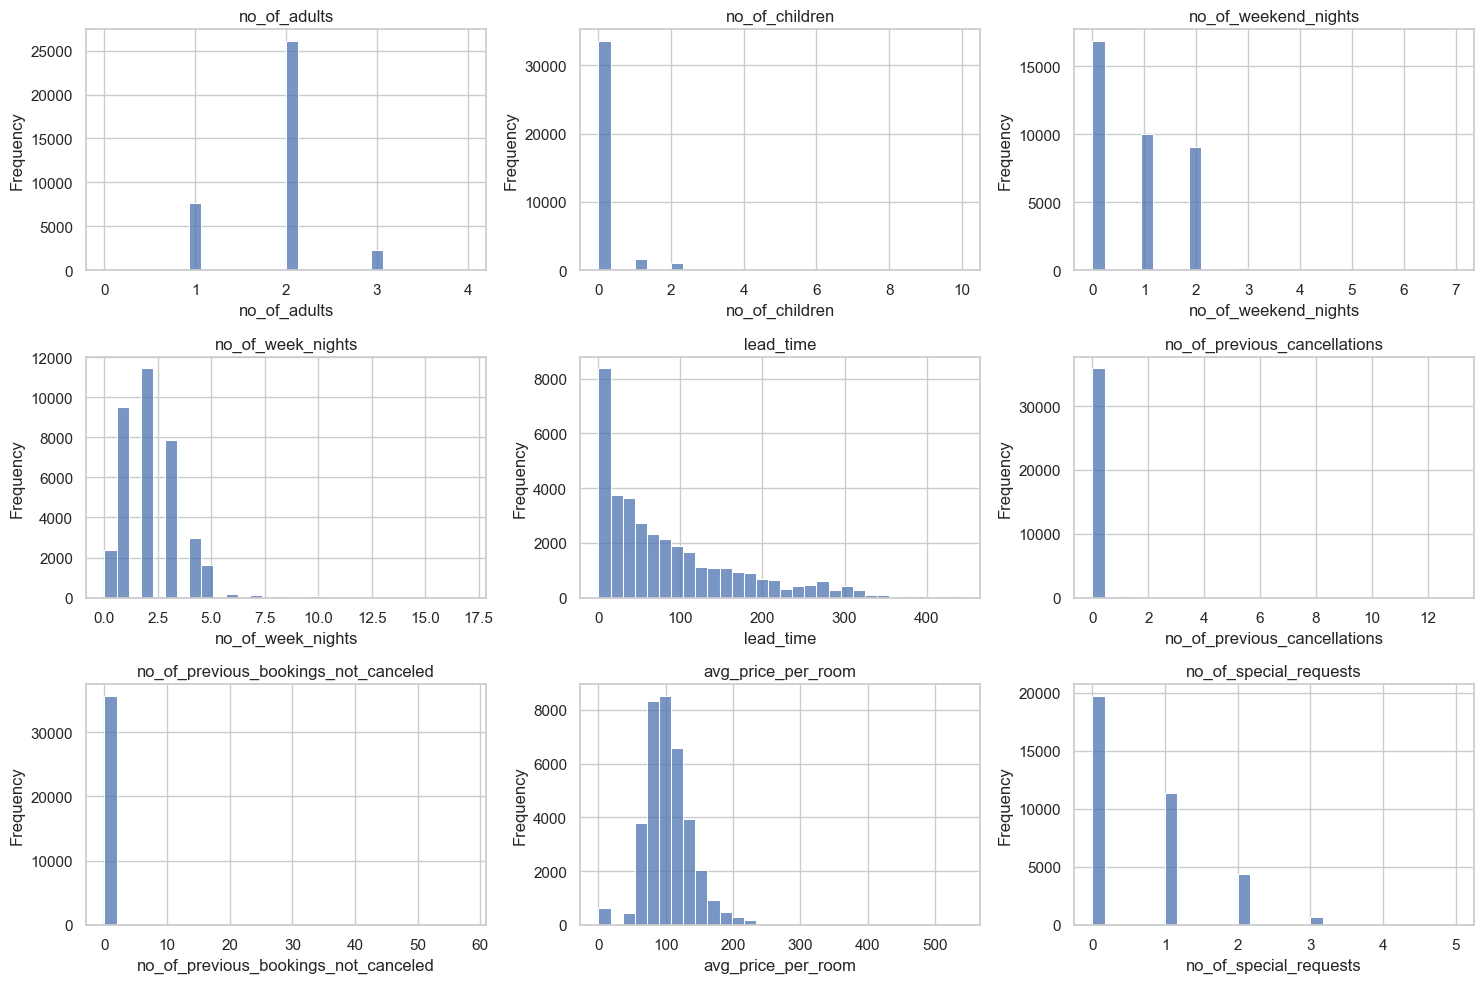

In [54]:
sns.set(style="whitegrid")

numerical_features = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 
                      'no_of_week_nights', 'lead_time', 'no_of_previous_cancellations', 
                      'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 
                      'no_of_special_requests']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1)
    sns.histplot(data[feature],  bins=30)
    plt.title(f'{feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



## Analiza zmiennych kategorycznych

`Typ Planu Posiłków`

Większość rezerwacji obejmuje "Meal Plan 1", co sugeruje, że jest to najpopularniejszy i prawdopodobnie najbardziej podstawowy plan oferowany przez hotel.

`Typy Zarezerwowanych Pokoi`

Dominująca liczba rezerwacji dotyczy "Room Type 1", co może wskazywać na to, że jest to standardowy typ pokoju oferowany przez hotel.

`Segmenty Rynkowe`

Najwięcej rezerwacji pochodzi z segmentu "Online", co podkreśla znaczenie internetowych kanałów sprzedaży w branży hotelarskiej.

`Status Powtarzającego się Gościa`

Większość rezerwacji pochodzi od nowych gości.


`Wymagania Miejsca Parkingowego`

Zdecydowana większość gości nie wymaga miejsca parkingowego.


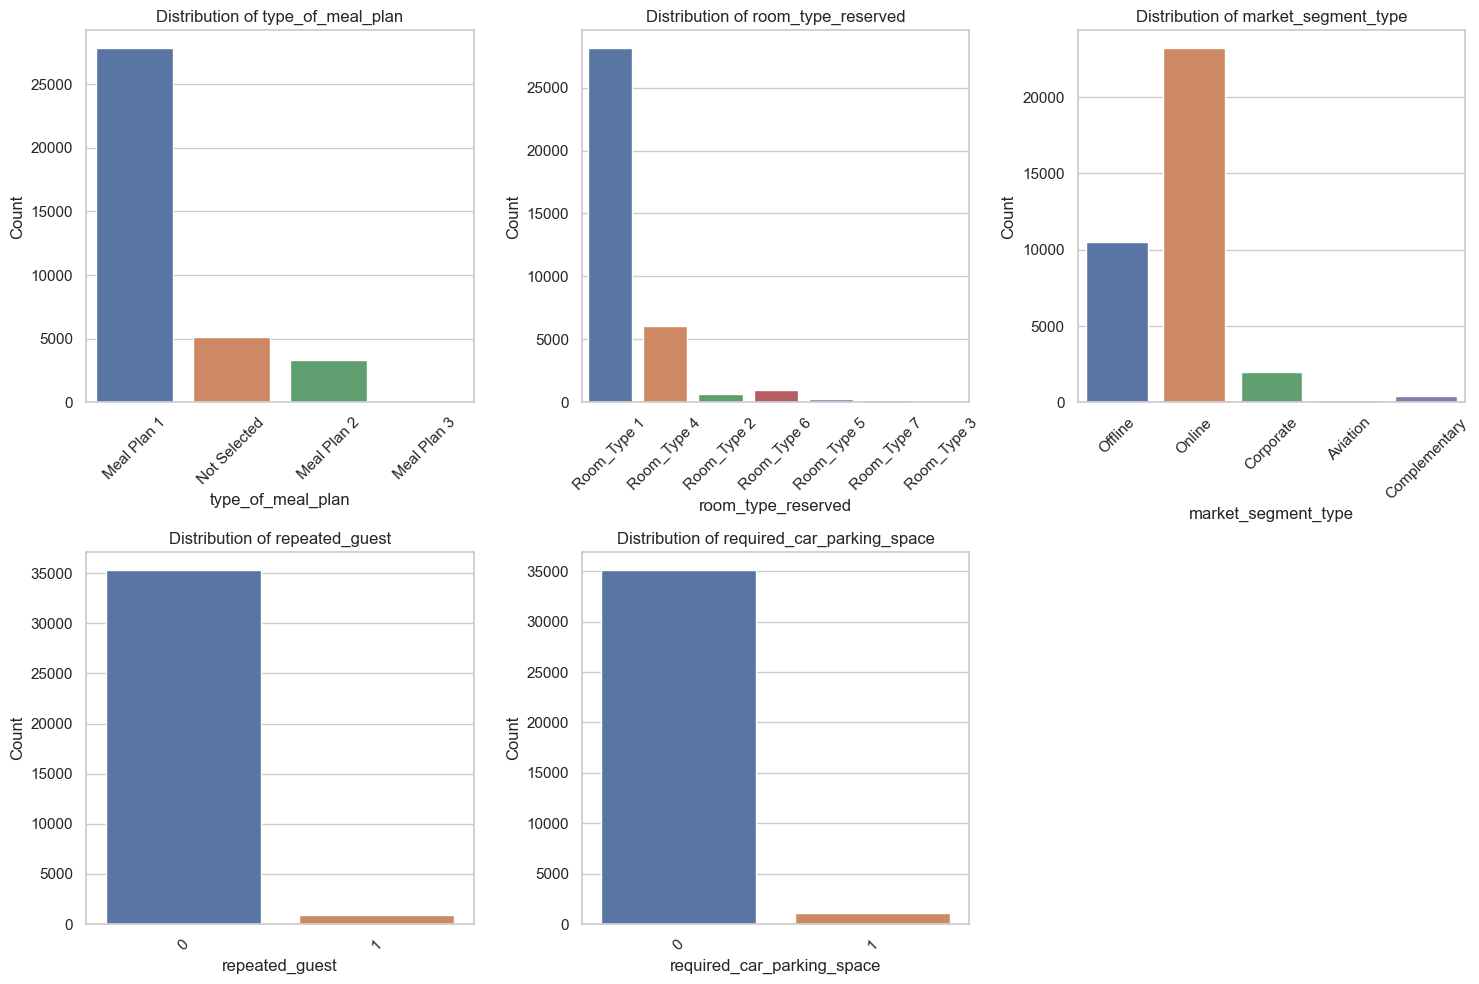

In [55]:
# Wykres słupkowy dla zmiennych kategorycznych
categorical_features = ['type_of_meal_plan', 'room_type_reserved', 
                        'market_segment_type', 'repeated_guest', 
                        'required_car_parking_space']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(categorical_features):
    plt.subplot(2, 3, i + 1)  # 2 rzędy i 3 kolumny dla 6 zmiennych
    sns.countplot(data=data, x=feature)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Analiza wskaźnika anulowania rezerwacji

`Typ Planu Posiłków`

Goście, którzy wybrali plan posiłku 2, mają najwyższy wskaźnik anulowania.

`Typ Pokoju`

Pokoje typu 1,2,4,6 mają stosunkowo wysokie wskaźniki anulowania w porównaniu do innych typów. Analiza ta może wskazać na potrzebę przeglądu warunków rezerwacji dla tych specyficznych typów pokoi.

`Segment Rynku`

Segment Online wykazuje najwyższy wskaźnik anulowania.

`Powtarzający Się Gość`

Powtarzający się goście mają znacznie niższy wskaźnik anulowania rezerwacji w porównaniu do nowych gości. To może sugerować większą lojalność i mniejszą niepewność wśród gości, którzy wcześniej korzystali z usług hotelu.

`Wymagania Miejsca Parkingowego`

Goście wymagający miejsca parkingowego mają znacząco niższy wskaźnik anulowania niż goście, którzy nie potrzebują parkingu.


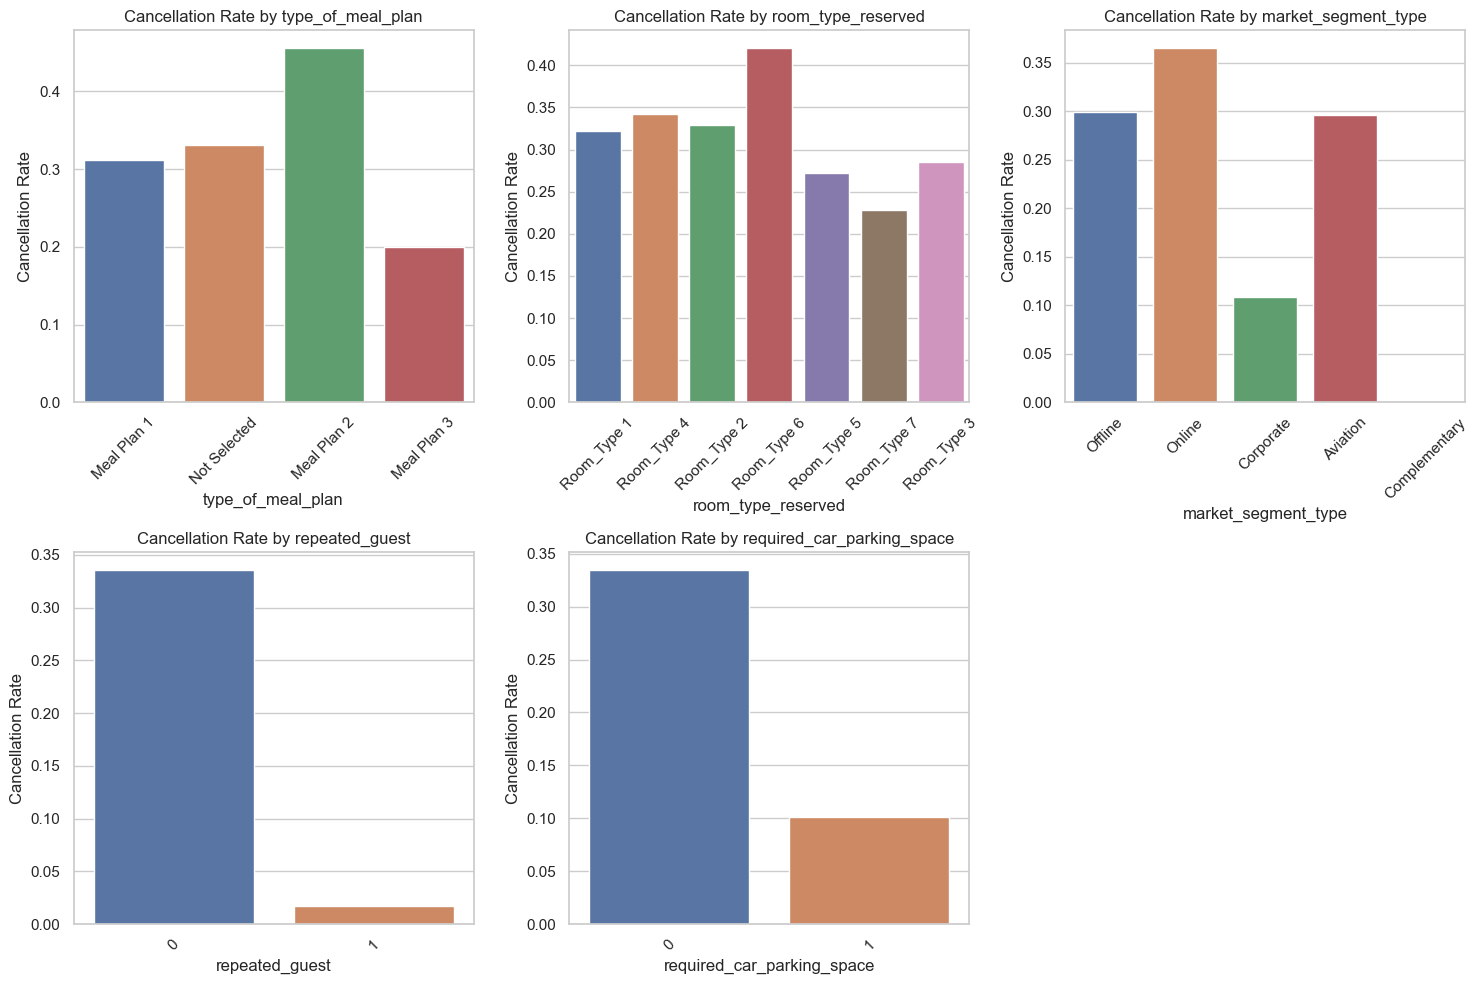

In [56]:
# Wykres proporcji odwołanych rezerwacji dla wybranych zmiennych kategorycznych
plt.figure(figsize=(15, 10))
for i, feature in enumerate(categorical_features):
    plt.subplot(2, 3, i + 1)
    sns.barplot(x=feature, y=data['booking_status'].apply(lambda x: 1 if x == 'Canceled' else 0), data=data, errorbar=None)
    plt.title(f'Cancellation Rate by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Cancellation Rate')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Analiza Statusu Odwołania

- 67,2% rezerwacji nie została anulowana.
- Liczba rezerwacji nieanulowanych wynosi 24 390, natomiast anulowanych 11 885.


Not_Canceled    24390
Canceled        11885
Name: booking_status, dtype: int64


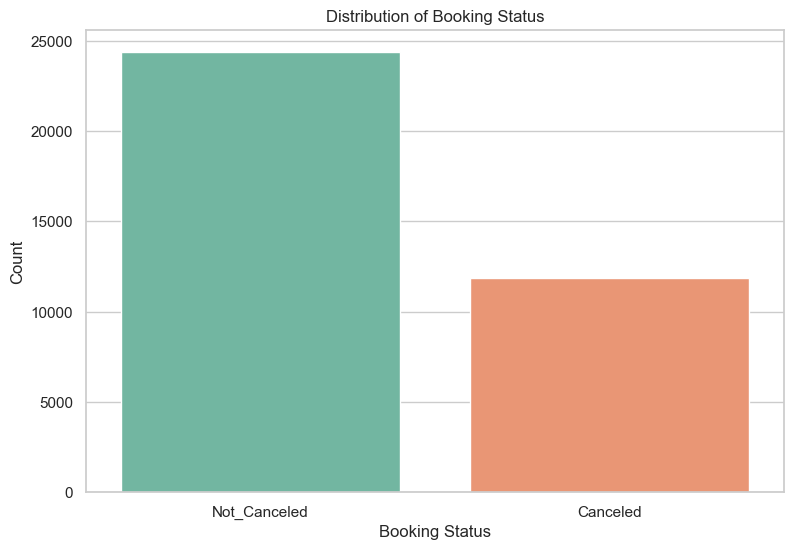

In [57]:
print(data['booking_status'].value_counts())

# Ustawienie stylu wykresów
sns.set(style="whitegrid")

# Wykres słupkowy dla zmiennej 'booking_status'
plt.figure(figsize=(9, 6))
ax = sns.countplot(data=data, x='booking_status', palette='Set2')
plt.title('Distribution of Booking Status')
plt.xlabel('Booking Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

## Analiza Macierzy Korelacji

### Kluczowe obserwacje

`Czas oczekiwania`

Ma stosunkowo silną dodatnią korelację ze statusem rezerwacji (0.44). Oznacza to, że im dłuższy czas oczekiwania, tym większe prawdopodobieństwo anulowania rezerwacji.

`Liczba specjalnych życzeń`

Ma umiarkowaną ujemną korelację ze statusem rezerwacji (-0.25). Sugeruje to, że większa liczba specjalnych życzeń jest związana z mniejszym prawdopodobieństwem anulowania rezerwacji.

`Powtarzający się gość`

Ma słabą ujemną korelację ze statusem rezerwacji (-0.11). Oznacza to, że powtarzający się goście mogą być mniej skłonni do anulowania rezerwacji.

`Średnia cena za pokój`

Ma słabą dodatnią korelację ze statusem rezerwacji (0.13). Wyższa cena za pokój jest nieznacznie związana z większym prawdopodobieństwem anulowania rezerwacji.


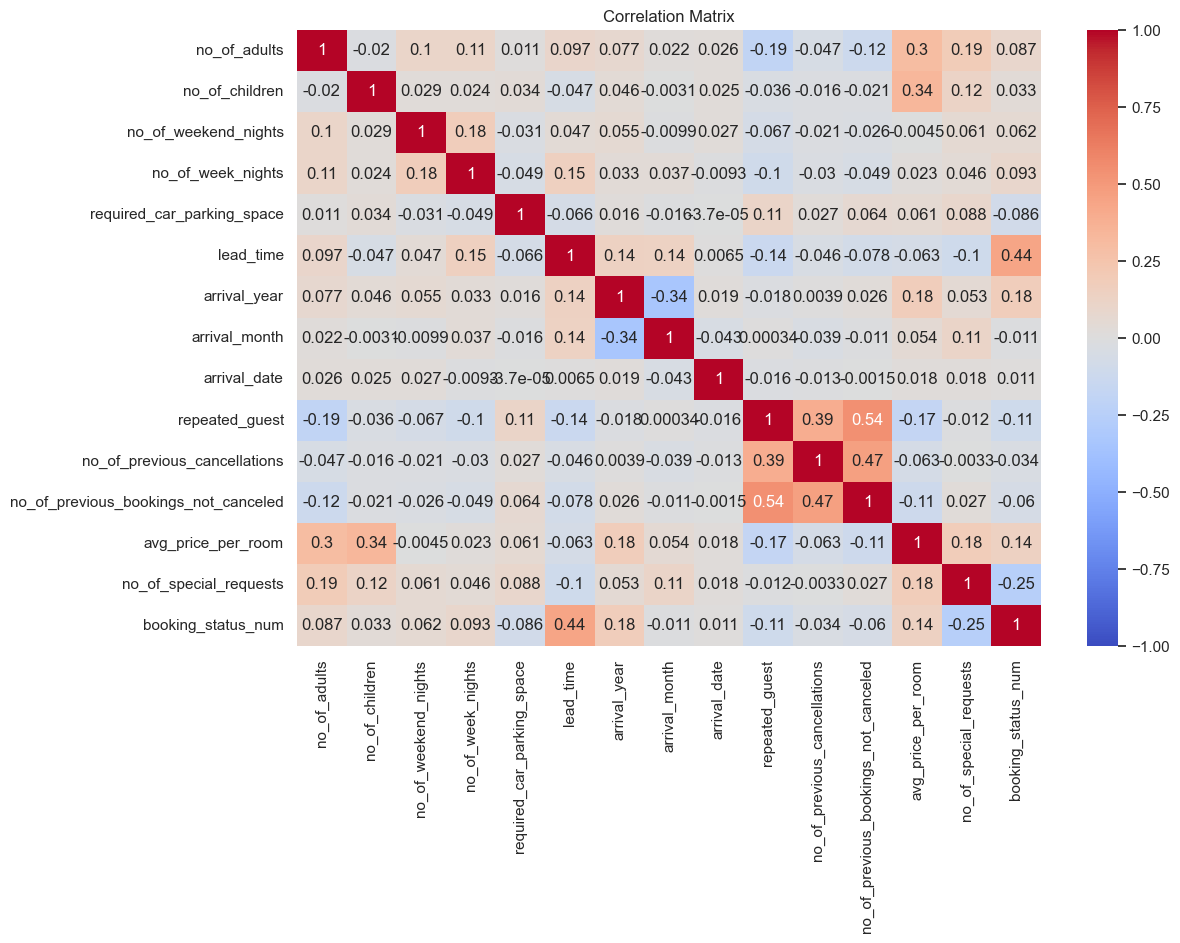

In [58]:
# Mapowanie statusu rezerwacji na wartości numeryczne
data['booking_status_num'] = data['booking_status'].apply(lambda x: 1 if x == 'Canceled' else 0)

# Obliczanie macierzy korelacji z jawnym określeniem argumentu numeric_only
correlation_matrix = data.corr(numeric_only=True)

# Wizualizacja macierzy korelacji
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

# Usunięcie dodatkowej kolumny
data.drop(columns=['booking_status_num'], inplace=True)


# Budowa modeli

* Wartości w kolumnie booking_status zostały przekonwertowane na wartości binarne (0 dla Not_Canceled i 1 dla Canceled).
* Przetworzono dane, konwertując kolumny kategoryczne na zmienne numeryczne za pomocą metody one-hot encoding. 
* Odrzucono kolumny, które nie mają bezpośredniego wpływu na przewidywanie statusu rezerwacji (Booking_ID, arrival_year, arrival_month, arrival_date). Następnie podzielono dane na zbiór treningowy (80%) i testowy (20%).


In [59]:
# Konwersja wartości w kolumnie 'booking_status' na wartości binarne (0 - Not_Canceled, 1 - Canceled)
data['booking_status'] = data['booking_status'].apply(lambda x: 1 if x == 'Canceled' else 0)
#data['booking_status']


# Przetwarzanie danych
# Konwersja kolumn kategorycznych na zmienne numeryczne przy użyciu metody one-hot encoding
categorical_cols = ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Odrzucenie kolumn, które nie mają bezpośredniego wpływu na przewidywanie statusu rezerwacji
# Usunięto kolumny 'Booking_ID', 'arrival_year', 'arrival_month', 'arrival_date'
X = data.drop(columns=['Booking_ID', 'booking_status', 'arrival_year', 'arrival_month', 'arrival_date'])
y = data['booking_status']  # Zmienna docelowa to 'booking_status'

# Podział danych na zbiór treningowy i testowy
# 80% danych będzie używane do trenowania modelu, a 20% do testowania
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)


Training set size: (29020, 24)
Test set size: (7255, 24)


## Regresja logistyczna

### Krok 1: Selekcja cech metodą forward selection
W tym kroku użyto metody forward selection, aby wybrać najbardziej istotne cechy. Proces ten polega na dodawaniu cech jedna po drugiej do modelu i sprawdzaniu, która kombinacja cech daje najlepsze wyniki. Metoda wybrała następujące cechy: `'lead_time', 'no_of_previous_bookings_not_canceled', 'no_of_special_requests', 'type_of_meal_plan_Meal Plan 2', 'type_of_meal_plan_Not Selected', 'room_type_reserved_Room_Type 4', 'market_segment_type_Corporate', 'market_segment_type_Offline'`.

In [ ]:

# Forward Selection
# Tworzenie obiektu SequentialFeatureSelector dla regresji logistycznej
sfs_forward = SFS(LogisticRegression(max_iter=1000, random_state=42), 
                  k_features='best',  # Automatyczny wybór optymalnej liczby cech
                  forward=True,       # Selekcja w przód
                  floating=False,     # Bez floating stepwise selection
                  scoring='accuracy', # Używanie dokładności jako metryki oceny
                  cv=5)               # Walidacja krzyżowa z 5 fałdami

# Dopasowanie selektora cech do danych treningowych
sfs_forward = sfs_forward.fit(X_train, y_train)

# Lista wybranych cech przez forward selection
selected_features_forward = list(sfs_forward.k_feature_names_)
print(f"Selected features (forward): {selected_features_forward}")

# Aktualizacja zbiorów treningowych i testowych na podstawie wybranych cech
X_train_selected = X_train[selected_features_forward]
X_test_selected = X_test[selected_features_forward]


### Krok 2: Selekcja cech metodą backward selection
Następnie zastosowano metodę backward selection, która polega na rozpoczynaniu z pełnym zestawem cech i usuwaniu ich jedna po drugiej, aż pozostanie optymalny zestaw cech. Metoda wybrała następujące cechy: `'lead_time', 'no_of_special_requests', 'market_segment_type_Offline'`.

In [ ]:

# Backward Selection

# Tworzenie obiektu SequentialFeatureSelector dla regresji logistycznej
sfs_backward = SFS(LogisticRegression(max_iter=1000, random_state=42),
                   k_features='best',  # Automatyczny wybór optymalnej liczby cech
                   forward=False,      # Selekcja wstecz
                   floating=False,     # Bez floating stepwise selection
                   scoring='accuracy', # Używanie dokładności jako metryki oceny
                   cv=5)               # Walidacja krzyżowa z 5 fałdami

# Dopasowanie selektora cech do danych treningowych
sfs_backward = sfs_backward.fit(X_train, y_train)

# Lista wybranych cech przez backward selection
selected_features_backward = list(sfs_backward.k_feature_names_)
print(f"Selected features (backward): {selected_features_backward}")

# Aktualizacja zbiorów treningowych i testowych na podstawie wybranych cech
X_train_selected_backward = X_train[selected_features_backward]
X_test_selected_backward = X_test[selected_features_backward]




### Krok 3: Selekcja cech metodą stepwise selection
Zastosowano również metode stepwise selection, która łączy podejścia forward i backward, dodając i usuwając cechy, aby znaleźć najlepszą kombinację. Metoda wybrała następujące cechy: `'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'required_car_parking_space', 'no_of_previous_cancellations', 'no_of_special_requests', 'room_type_reserved_Room_Type 6', 'market_segment_type_Complementary', 'market_segment_type_Online'`.

In [ ]:

# Stepwise Selection
# Tworzenie obiektu SequentialFeatureSelector dla regresji logistycznej
sfs_stepwise = SFS(LogisticRegression(max_iter=500, random_state=42), 
                   k_features='best',  # Automatyczny wybór optymalnej liczby cech
                   forward=True,       # Selekcja w przód
                   floating=True,      # Z floating stepwise selection
                   scoring='accuracy', # Używanie dokładności jako metryki oceny
                   cv=5)               # Walidacja krzyżowa z 5 fałdami

# Dopasowanie selektora cech do danych treningowych
sfs_stepwise = sfs_stepwise.fit(X_train, y_train)

# Lista wybranych cech przez stepwise selection
selected_features_stepwise = list(sfs_stepwise.k_feature_names_)
print(f"Selected features (stepwise): {selected_features_stepwise}")

# Aktualizacja zbiorów treningowych i testowych na podstawie wybranych cech
X_train_selected_stepwise = X_train[selected_features_stepwise]
X_test_selected_stepwise = X_test[selected_features_stepwise]


### Krok 4: Trenowanie modelu regresji logistycznej na podstawie wybranych cech (forward selection) i ocena
Na podstawie cech wybranych metodą forward selection przeprowadzono model regresji logistycznej i oceniono jego wydajność na zbiorze testowym. Wyniki modelu są następujące:

- Accuracy: 0.8036
- Precision: 0.7506
- Recall: 0.6142
- F1 Score: 0.6756
- ROC AUC: 0.8573
- Mean Squared Error: 0.1964
- Mean Absolute Error: 0.1964
- R^2 Score: 0.1157



Accuracy (forward): 0.8035837353549277
Precision (forward): 0.7506322711178554
Recall (forward): 0.6142384105960265
F1 Score (forward): 0.6756203050307307
ROC AUC (forward): 0.8573138246914898
Mean Squared Error (forward): 0.19641626464507236
Mean Absolute Error (forward): 0.19641626464507236
R^2 Score (forward): 0.11569978814516124
Classification Report (forward):
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      4839
           1       0.75      0.61      0.68      2416

    accuracy                           0.80      7255
   macro avg       0.79      0.76      0.77      7255
weighted avg       0.80      0.80      0.80      7255



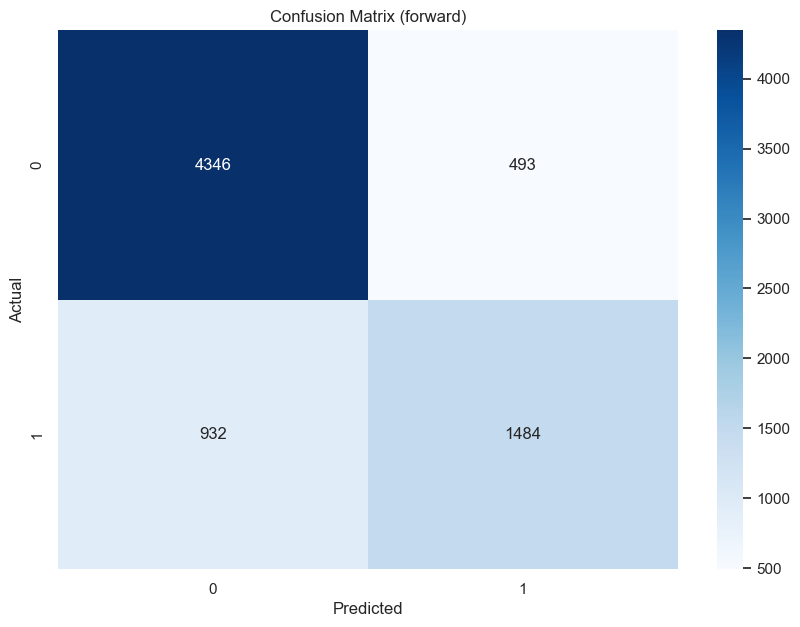

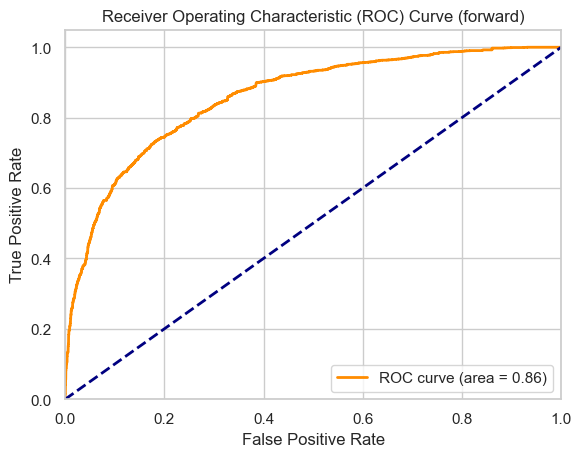

In [14]:
# Trenowanie modelu regresji logistycznej na podstawie wybranych cech (forward)
log_reg = LogisticRegression(max_iter=2000, random_state=42)
log_reg.fit(X_train_selected, y_train)

# Przewidywanie na zbiorze testowym (forward)
y_pred = log_reg.predict(X_test_selected)
y_pred_prob = log_reg.predict_proba(X_test_selected)[:, 1]

# Ocena modelu (forward)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = auc(*roc_curve(y_test, y_pred_prob, pos_label=1)[:2])
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Accuracy (forward): {accuracy}')
print(f'Precision (forward): {precision}')
print(f'Recall (forward): {recall}')
print(f'F1 Score (forward): {f1}')
print(f'ROC AUC (forward): {roc_auc}')
print(f'Mean Squared Error (forward): {mse}')
print(f'Mean Absolute Error (forward): {mae}')
print(f'R^2 Score (forward): {r2}')

print('Classification Report (forward):')
print(classification_report(y_test, y_pred))

# Macierz pomyłek z wizualizacją (forward)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (forward)')
plt.show()

# Krzywa ROC i AUC (forward)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (forward)')
plt.legend(loc='lower right')
plt.show()


### Krok 5: Trenowanie modelu regresji logistycznej na podstawie wybranych cech (backward selection) i ocena
Podobnie, przeprowadzono trening modelu regresji logistycznej na podstawie cech wybranych metodą backward selection i oceniono jego wydajność. Wyniki modelu są następujące:

- Accuracy: 0.8052
- Precision: 0.7539
- Recall: 0.6163
- F1 Score: 0.6782
- ROC AUC: 0.8604
- Mean Squared Error: 0.1948
- Mean Absolute Error: 0.1948
- R^2 Score: 0.1231


Accuracy (backward): 0.805237767057202
Precision (backward): 0.7539240506329113
Recall (backward): 0.6163079470198676
F1 Score (backward): 0.6782054201776361
ROC AUC (backward): 0.8603534215651255
Mean Squared Error (backward): 0.19476223294279807
Mean Absolute Error (backward): 0.19476223294279807
R^2 Score (backward): 0.12314652677130722
Classification Report (backward):
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      4839
           1       0.75      0.62      0.68      2416

    accuracy                           0.81      7255
   macro avg       0.79      0.76      0.77      7255
weighted avg       0.80      0.81      0.80      7255



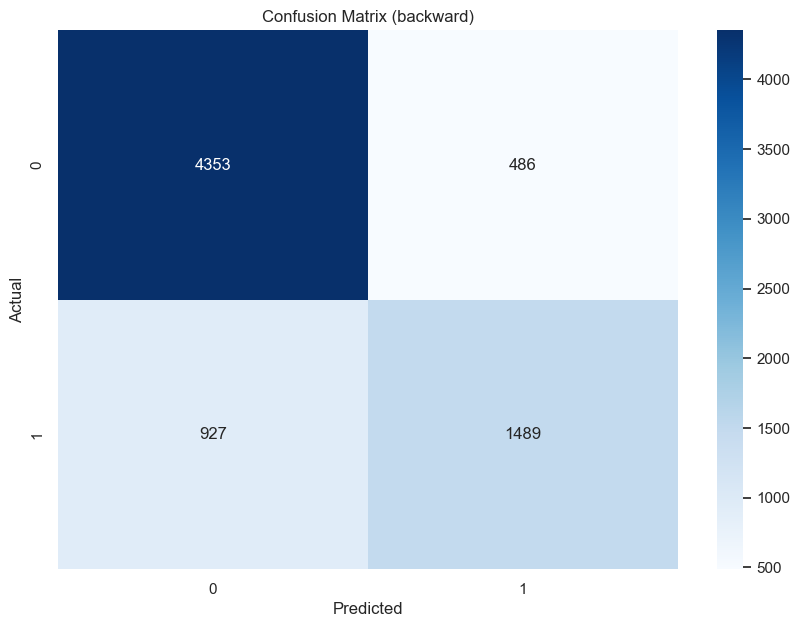

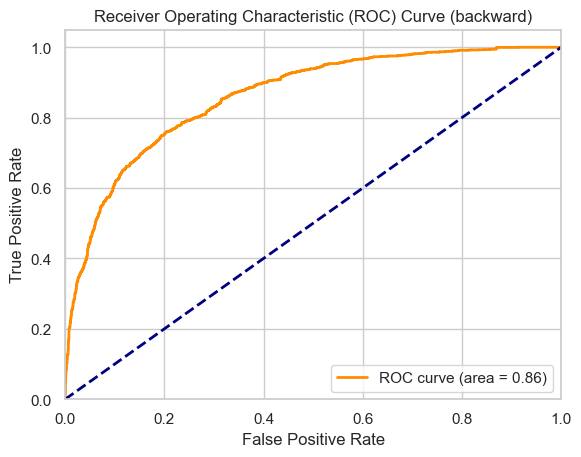

In [15]:
# Trenowanie modelu regresji logistycznej na podstawie wybranych cech (backward)
log_reg_backward = LogisticRegression(max_iter=2000, random_state=42)
log_reg_backward.fit(X_train_selected_backward, y_train)

# Przewidywanie na zbiorze testowym (backward)
y_pred_backward = log_reg_backward.predict(X_test_selected_backward)
y_pred_prob_backward = log_reg_backward.predict_proba(X_test_selected_backward)[:, 1]

# Ocena modelu (backward)
accuracy_backward = accuracy_score(y_test, y_pred_backward)
precision_backward = precision_score(y_test, y_pred_backward)
recall_backward = recall_score(y_test, y_pred_backward)
f1_backward = f1_score(y_test, y_pred_backward)
roc_auc_backward = auc(*roc_curve(y_test, y_pred_prob_backward, pos_label=1)[:2])
mse_backward = mean_squared_error(y_test, y_pred_backward)
mae_backward = mean_absolute_error(y_test, y_pred_backward)
r2_backward = r2_score(y_test, y_pred_backward)

print(f'Accuracy (backward): {accuracy_backward}')
print(f'Precision (backward): {precision_backward}')
print(f'Recall (backward): {recall_backward}')
print(f'F1 Score (backward): {f1_backward}')
print(f'ROC AUC (backward): {roc_auc_backward}')
print(f'Mean Squared Error (backward): {mse_backward}')
print(f'Mean Absolute Error (backward): {mae_backward}')
print(f'R^2 Score (backward): {r2_backward}')

print('Classification Report (backward):')
print(classification_report(y_test, y_pred_backward))

# Macierz pomyłek z wizualizacją (backward)
conf_matrix_backward = confusion_matrix(y_test, y_pred_backward)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_backward, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (backward)')
plt.show()

# Krzywa ROC i AUC (backward)
fpr_backward, tpr_backward, thresholds_backward = roc_curve(y_test, y_pred_prob_backward, pos_label=1)
plt.figure()
plt.plot(fpr_backward, tpr_backward, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_backward:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (backward)')
plt.legend(loc='lower right')
plt.show()


### Krok 6: Trenowanie modelu regresji logistycznej na podstawie wybranych cech (stepwise selection) i ocena
Następnie przeszkolono model regresji logistycznej na podstawie cech wybranych metodą stepwise selection i oceniono jego wydajność. Wyniki modelu są następujące:

- Accuracy: 0.8032
- Precision: 0.7497
- Recall: 0.6138
- F1 Score: 0.6750
- ROC AUC: 0.8577
- Mean Squared Error: 0.1968
- Mean Absolute Error: 0.1968
- R^2 Score: 0.1138


Accuracy (stepwise): 0.8031702274293591
Precision (stepwise): 0.749747219413549
Recall (stepwise): 0.6138245033112583
F1 Score (stepwise): 0.6750113791533909
ROC AUC (stepwise): 0.8577029266213123
Mean Squared Error (stepwise): 0.19682977257064094
Mean Absolute Error (stepwise): 0.19682977257064094
R^2 Score (stepwise): 0.11383810348862478
Classification Report (stepwise):
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      4839
           1       0.75      0.61      0.68      2416

    accuracy                           0.80      7255
   macro avg       0.79      0.76      0.77      7255
weighted avg       0.80      0.80      0.80      7255



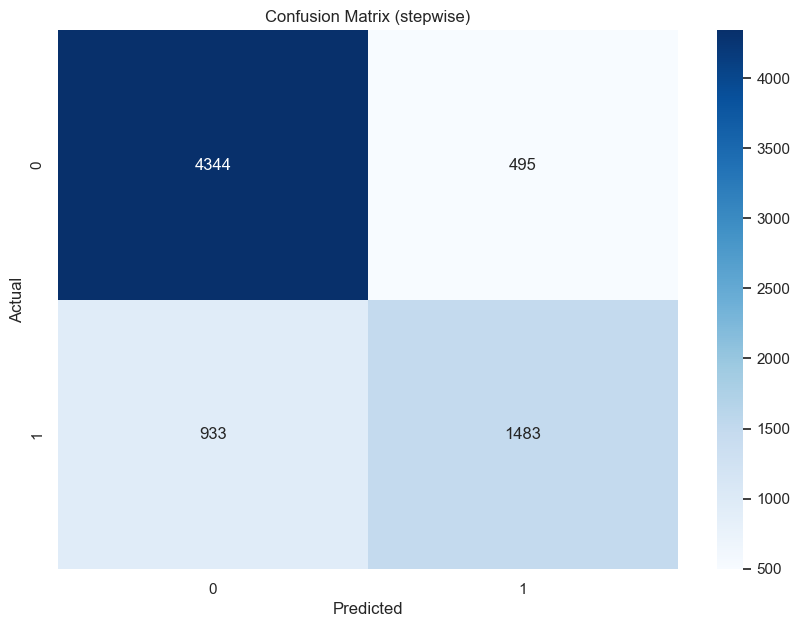

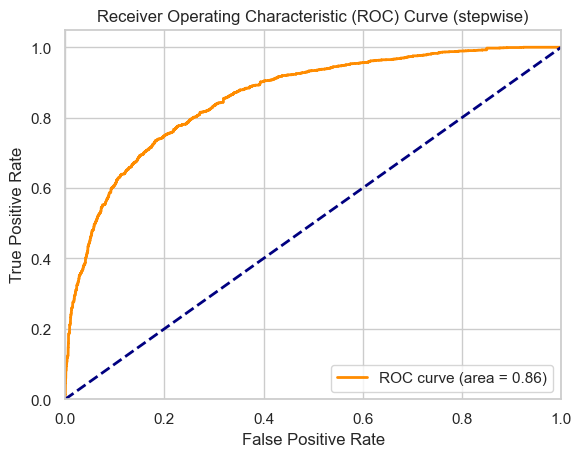

In [16]:
# Trenowanie modelu regresji logistycznej na podstawie wybranych cech (stepwise)
log_reg_stepwise = LogisticRegression(max_iter=2000, random_state=42)
log_reg_stepwise.fit(X_train_selected_stepwise, y_train)

# Przewidywanie na zbiorze testowym (stepwise)
y_pred_stepwise = log_reg_stepwise.predict(X_test_selected_stepwise)
y_pred_prob_stepwise = log_reg_stepwise.predict_proba(X_test_selected_stepwise)[:, 1]

# Ocena modelu (stepwise)
accuracy_stepwise = accuracy_score(y_test, y_pred_stepwise)
precision_stepwise = precision_score(y_test, y_pred_stepwise)
recall_stepwise = recall_score(y_test, y_pred_stepwise)
f1_stepwise = f1_score(y_test, y_pred_stepwise)
roc_auc_stepwise = auc(*roc_curve(y_test, y_pred_prob_stepwise, pos_label=1)[:2])
mse_stepwise = mean_squared_error(y_test, y_pred_stepwise)
mae_stepwise = mean_absolute_error(y_test, y_pred_stepwise)
r2_stepwise = r2_score(y_test, y_pred_stepwise)

print(f'Accuracy (stepwise): {accuracy_stepwise}')
print(f'Precision (stepwise): {precision_stepwise}')
print(f'Recall (stepwise): {recall_stepwise}')
print(f'F1 Score (stepwise): {f1_stepwise}')
print(f'ROC AUC (stepwise): {roc_auc_stepwise}')
print(f'Mean Squared Error (stepwise): {mse_stepwise}')
print(f'Mean Absolute Error (stepwise): {mae_stepwise}')
print(f'R^2 Score (stepwise): {r2_stepwise}')

print('Classification Report (stepwise):')
print(classification_report(y_test, y_pred_stepwise))

# Macierz pomyłek z wizualizacją (stepwise)
conf_matrix_stepwise = confusion_matrix(y_test, y_pred_stepwise)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_stepwise, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (stepwise)')
plt.show()

# Krzywa ROC i AUC (stepwise)
fpr_stepwise, tpr_stepwise, thresholds_stepwise = roc_curve(y_test, y_pred_prob_stepwise, pos_label=1)
plt.figure()
plt.plot(fpr_stepwise, tpr_stepwise, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_stepwise:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (stepwise)')
plt.legend(loc='lower right')
plt.show()


### Krok 7: Grid Search CV dla znalezienia najlepszych parametrów modelu
W celu optymalizacji modelu regresji logistycznej, zastosowano Grid Search CV do znalezienia najlepszych parametrów. Przetestowano różne wartości parametru regularizacji C oraz różne solvery. Wyniki Grid Search CV wskazały, że najlepsze parametry to {'C': 100, 'solver': 'liblinear'}.

W tym kroku użyto zmiennych wybranych przez metodę Forward Selection.

Model z tymi parametrami został oceniony na zbiorze testowym, uzyskując następujące wyniki:

- Best Model Accuracy: 0.8036
- Best Model Precision: 0.7504
- Best Model Recall: 0.6147
- Best Model F1 Score: 0.6758
- Best Model ROC AUC: 0.8573


Best Parameters: {'C': 100, 'solver': 'liblinear'}
Best Model Accuracy: 0.8035837353549277
Best Model Precision: 0.7503789792824659
Best Model Recall: 0.6146523178807947
Best Model F1 Score: 0.6757679180887372
Best Model ROC AUC: 0.8573421370104108


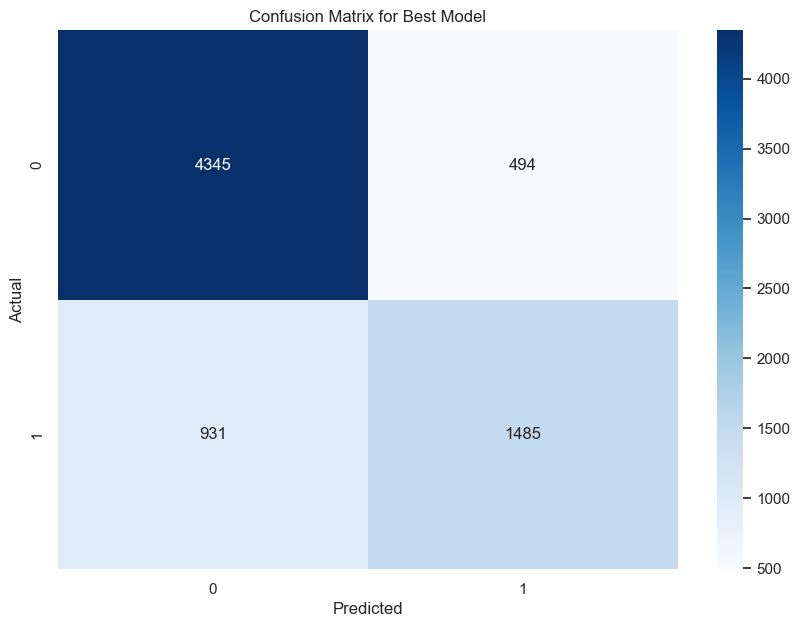

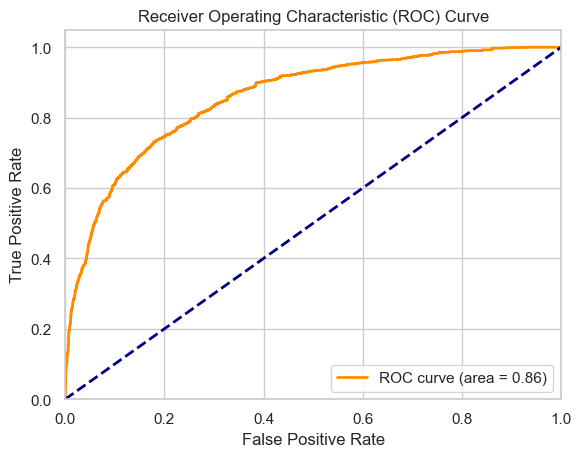

In [17]:
# Parametry do przetestowania
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

# Utworzenie i trenowanie GridSearchCV
grid_search = GridSearchCV(estimator=LogisticRegression(max_iter=5000, random_state=42), 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='accuracy')

grid_search.fit(X_train_selected, y_train)

# Wyświetlenie najlepszych parametrów i ich wyników
print(f'Best Parameters: {grid_search.best_params_}')
best_model = grid_search.best_estimator_

# Ocenianie modelu na zbiorze testowym
y_pred_best = best_model.predict(X_test_selected)
y_pred_prob_best = best_model.predict_proba(X_test_selected)[:, 1]

accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)
roc_auc_best = auc(*roc_curve(y_test, y_pred_prob_best, pos_label=1)[:2])

print(f'Best Model Accuracy: {accuracy_best}')
print(f'Best Model Precision: {precision_best}')
print(f'Best Model Recall: {recall_best}')
print(f'Best Model F1 Score: {f1_best}')
print(f'Best Model ROC AUC: {roc_auc_best}')

# Macierz pomyłek dla najlepszego modelu
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Best Model')
plt.show()

# Krzywa ROC dla najlepszego modelu
fpr_best, tpr_best, thresholds_best = roc_curve(y_test, y_pred_prob_best, pos_label=1)
plt.figure()
plt.plot(fpr_best, tpr_best, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_best:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


### Krok 8: Walidacja krzyżowa dla najlepszego modelu

In [18]:
# Przeprowadzanie walidacji krzyżowej
cv_scores = cross_val_score(best_model, X_train_selected, y_train, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean()}')



Cross-Validation Accuracy Scores: [0.80892488 0.80978635 0.79703653 0.79755341 0.80737422]
Mean CV Accuracy: 0.8041350792556857


### Krok 9 Zapisanie wyników modelu

In [19]:
# Inicjalizacja listy do przechowywania wyników różnych modeli
model_results = []

In [ ]:
# Zapisanie wyników modelu regresji logistycznej
log_reg_results = {
    'Model': 'Logistic Regression (Forward Selection + Grid Search)',
    'Best Parameters': {'C': 100, 'solver': 'liblinear'},
    'Accuracy': 0.8035837353549277,
    'Precision': 0.7503789792824659,
    'Recall': 0.6146523178807947,
    'F1 Score': 0.6757679180887372,
    'ROC AUC': 0.8573421370104108,
    'Cross-Validation Mean Accuracy': 0.8041350792556857,
    'Cross-Validation Scores': [0.80892488, 0.80978635, 0.79703653, 0.79755341, 0.80737422]
}

# Dodanie wyników modelu do listy
model_results.append(log_reg_results)

# Wyświetlenie zapisanych wyników
#print(model_results)

### Podsumowanie modelu regresji logistycznej

**Selekcja cech**

* Zastosowano metodę forward selection, aby wybrać najbardziej istotne cechy. Wybrane cechy to: `'lead_time', 'no_of_previous_bookings_not_canceled', 'no_of_special_requests', 'type_of_meal_plan_Meal Plan 2', 'type_of_meal_plan_Not Selected', 'room_type_reserved_Room_Type 4', 'market_segment_type_Corporate', 'market_segment_type_Offline'`.

**Optymalizacja modelu**

* Za pomocą Grid Search CV znaleziono optymalne parametry modelu regresji logistycznej. Najlepsze parametry to: `{'C': 100, 'solver': 'liblinear'}`.

**Ewaluacja modelu**

- Model został oceniony na zbiorze testowym, uzyskując następujące wyniki:
- Accuracy: 0.8036
- Precision: 0.7504
- Recall: 0.6147
- F1 Score: 0.6758
- ROC AUC: 0.8573

Przeprowadzono walidację krzyżową, aby ocenić stabilność modelu. Średnia dokładność z walidacji krzyżowej wyniosła 0.8041.

**Dokładność modelu**

- Model regresji logistycznej osiągnął dokładność na poziomie 80.36%, co oznacza, że model poprawnie przewiduje 80.36% przypadków.
- Wysoka precyzja (75.04%) wskazuje, że model skutecznie identyfikuje przypadki anulowania rezerwacji spośród tych, które przewidział jako anulowane.
- Recall (61.47%) wskazuje, że model identyfikuje ponad połowę wszystkich rzeczywistych przypadków anulowania.
- F1 Score (67.58%) jest harmoniczną średnią precision i recall, co oznacza, że model zachowuje pewną równowagę między tymi dwoma metrykami.
- Wartość ROC AUC (85.73%) sugeruje, że model dobrze radzi sobie z rozróżnianiem między anulowanymi i nieanulowanymi rezerwacjami.

**Walidacja krzyżowa**

* Średnia dokładność z walidacji krzyżowej wyniosła 80.41%, co potwierdza stabilność modelu i sugeruje, że model nie jest przetrenowany ani niedotrenowany.


## Drzewo decyzyjne

### Krok 1: Tworzenie początkowego modelu drzewa decyzyjnego i ocena ważności cech
Utworzono początkowy model drzewa decyzyjnego, aby ocenić ważność cech. Wizualizacja poniżej prezentuje, które cechy mają największy wpływ na model. Następnie ustalono próg ważności cech na poziomie 0.01 i wybrano te, które go przekroczyły. Ponownie podzielono dane na zbiory treningowy i testowy, aby skupić się na wybranych cechach.

Najważniejsze cechy wybrane na podstawie modelu drzewa decyzyjnego to:

- lead_time
- avg_price_per_room
- market_segment_type_Online
- no_of_special_requests
- no_of_week_nights
- no_of_weekend_nights
- no_of_adults
- room_type_reserved_Room_Type 4
- type_of_meal_plan_Not Selected
- required_car_parking_space


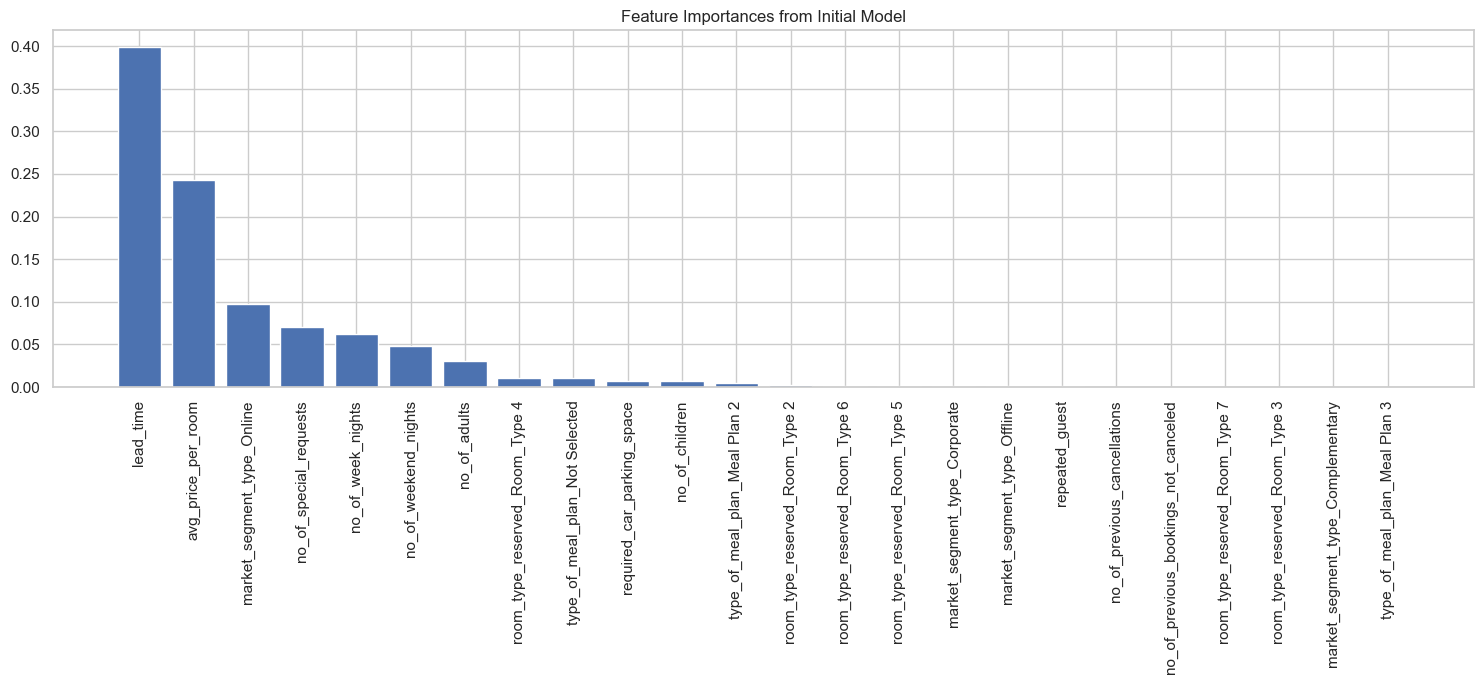

Training data shape: (29020, 9)
Test data shape: (7255, 9)


In [23]:
# Tworzenie i trenowanie początkowego modelu drzewa decyzyjnego
initial_tree = DecisionTreeClassifier(random_state=42)
initial_tree.fit(X_train, y_train)

# Ocena ważności cech w początkowym modelu
importances = initial_tree.feature_importances_
indices = np.argsort(importances)[::-1]

# Wizualizacja ważności cech
plt.figure(figsize=(15, 7))
plt.title('Feature Importances from Initial Model')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [X.columns[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

# Ustalamy próg ważności cech
threshold = 0.01

# Wybieramy cechy o ważności większej niż threshold
important_features = X.columns[importances > threshold]
X = X[important_features]

# Ponowny podział na zbiór treningowy i testowy z ważnymi cechami
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Sprawdzanie kształtu danych po podziale
print(f'Training data shape: {X_train.shape}')
print(f'Test data shape: {X_test.shape}')



### Krok 2: Modelowanie drzewa decyzyjnego
Stworzono i wytrenowano model drzewa decyzyjnego na podstawie wybranych cech. 
Przeprowadzono przewidywania na zbiorze testowym. 
Wyniki modelu są następujące:

- Accuracy: 0.8524
- Precision: 0.7803
- Recall: 0.7748
- F1 Score: 0.7776
- ROC AUC: 0.8358
- Mean Squared Error: 0.1476
- Mean Absolute Error: 0.1476
- R^2 Score: 0.3354


Accuracy: 0.8523776705720193
Precision: 0.7803251354731138
Recall: 0.7748344370860927
F1 Score: 0.7775700934579439
ROC AUC: 0.8358329432905107
Mean Squared Error: 0.1476223294279807
Mean Absolute Error: 0.1476223294279807
R^2 Score: 0.3353785776164685
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      4839
           1       0.78      0.77      0.78      2416

    accuracy                           0.85      7255
   macro avg       0.83      0.83      0.83      7255
weighted avg       0.85      0.85      0.85      7255



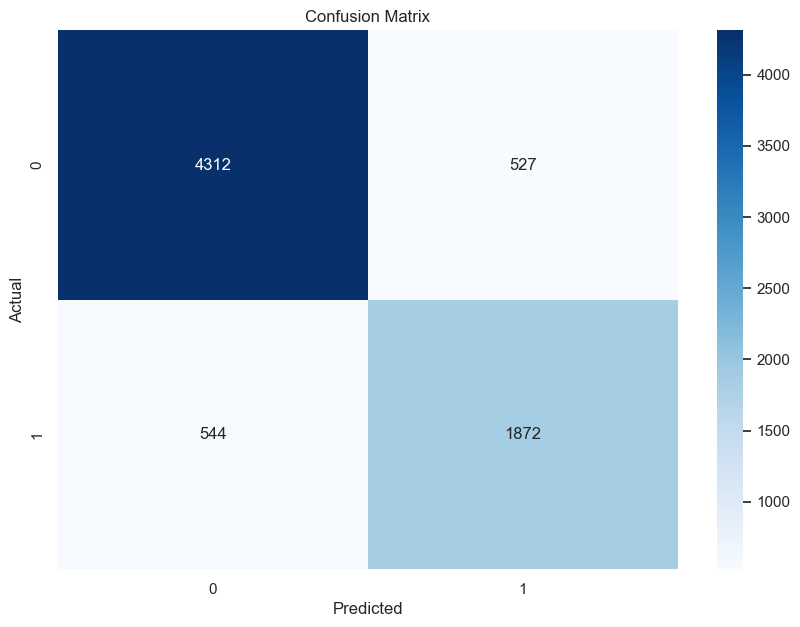

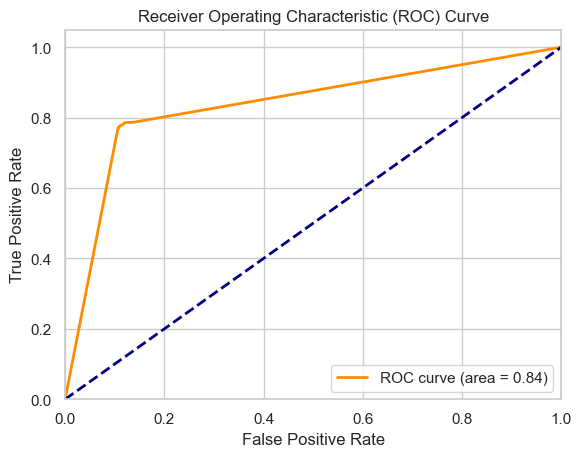

In [24]:
# Tworzenie i trenowanie modelu drzewa decyzyjnego
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

# Przewidywanie na zbiorze testowym
y_pred = tree.predict(X_test)
y_pred_prob = tree.predict_proba(X_test)[:, 1]

# Ocena modelu
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = auc(*roc_curve(y_test, y_pred_prob, pos_label=1)[:2])
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC: {roc_auc}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R^2 Score: {r2}')

print('Classification Report:')
print(classification_report(y_test, y_pred))

# Macierz pomyłek z wizualizacją
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Krzywa ROC i AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


### Krok 3: Optymalizacja modelu za pomocą Grid Search CV
Użyto Grid Search CV, aby znaleźć najlepsze parametry dla modelu drzewa decyzyjnego.

Najlepsze parametry:

- max_depth: 10
- min_samples_leaf: 1
- min_samples_split: 2

Po optymalizacji uzyskano wyniki najlepszego modelu:

- Accuracy: 0.8653
- Precision: 0.8213
- Recall: 0.7612
- F1 Score: 0.7901
- ROC AUC: 0.9195
- Mean Squared Error: 0.1347
- Mean Absolute Error: 0.1347
- R^2 Score: 0.3937

In [25]:
# Tuning parametrów drzewa decyzyjnego
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

grid_search = GridSearchCV(estimator=tree, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Najlepsze parametry i wynik
print(f'Best Parameters: {grid_search.best_params_}')
best_tree = grid_search.best_estimator_
y_pred_best = best_tree.predict(X_test)
y_pred_best_prob = best_tree.predict_proba(X_test)[:, 1]

print(f'Best Model Accuracy: {accuracy_score(y_test, y_pred_best)}')

# Obliczanie statystyk dla najlepszego modelu
precision_best = precision_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)
roc_auc_best = auc(*roc_curve(y_test, y_pred_best_prob, pos_label=1)[:2])
mse_best = mean_squared_error(y_test, y_pred_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f'Best Model Precision: {precision_best}')
print(f'Best Model Recall: {recall_best}')
print(f'Best Model F1 Score: {f1_best}')
print(f'Best Model ROC AUC: {roc_auc_best}')
print(f'Best Model Mean Squared Error: {mse_best}')
print(f'Best Model Mean Absolute Error: {mae_best}')
print(f'Best Model R^2 Score: {r2_best}')


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Model Accuracy: 0.8653342522398346
Best Model Precision: 0.8213488164359088
Best Model Recall: 0.7611754966887417
Best Model F1 Score: 0.7901181525241676
Best Model ROC AUC: 0.9194972570409573
Best Model Mean Squared Error: 0.1346657477601654
Best Model Mean Absolute Error: 0.1346657477601654
Best Model R^2 Score: 0.393711363521279


### Krok 4: Walidacja krzyżowa


In [26]:
# Krzyżowa walidacja z k=10
cv_scores = cross_val_score(best_tree, X, y, cv=10)
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean()}')


Cross-Validation Accuracy Scores: [0.85970232 0.87348401 0.87568908 0.86025358 0.86190739 0.86655638
 0.87124345 0.86297215 0.86324786 0.85552798]
Mean CV Accuracy: 0.8650584219359339


### Krok 5: Wizualizacja wyników i interpretacja


Macierz pomyłek pokazuje, że model prawidłowo klasyfikuje większość przypadków. 
* Dokładnie 4439 przypadków zostało prawidłowo sklasyfikowanych jako nieanulowane (True Negative)
* 1839 przypadków zostało prawidłowo sklasyfikowanych jako anulowane (True Positive). 
* Model popełnił 400 błędów typu False Positive i 577 błędów typu False Negative.

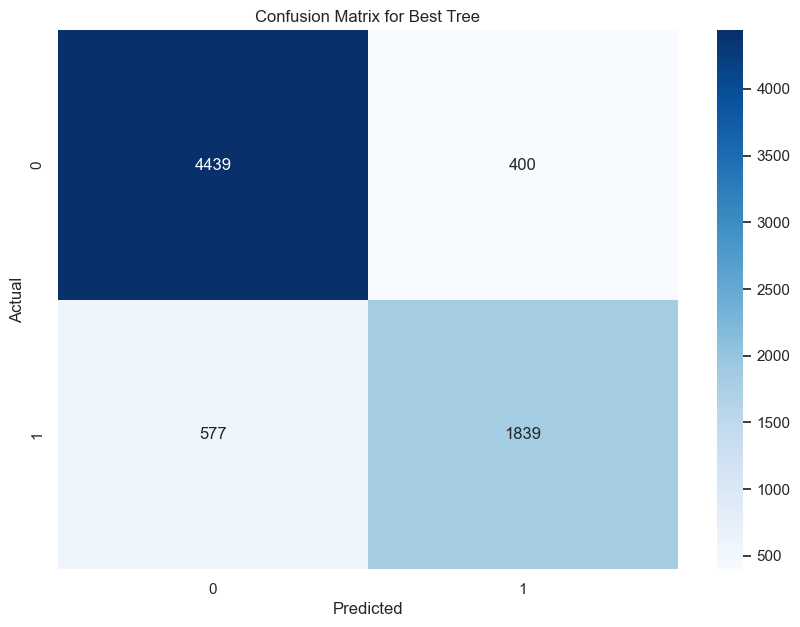

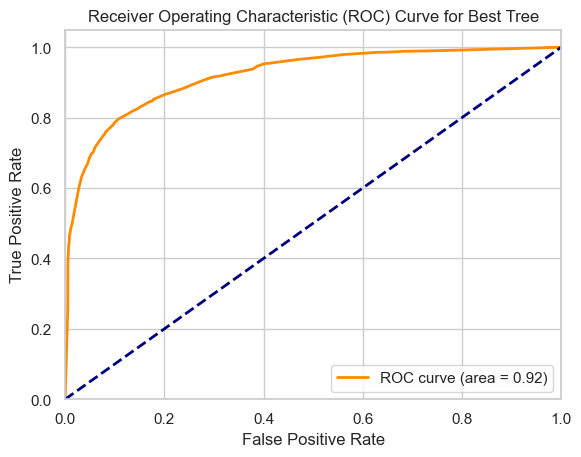

In [27]:
# Macierz pomyłek z wizualizacją dla najlepszego modelu drzewa decyzyjnego
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Best Tree')
plt.show()

# Krzywa ROC i AUC dla najlepszego modelu
fpr, tpr, thresholds = roc_curve(y_test, y_pred_best_prob, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Best Tree')
plt.legend(loc='lower right')
plt.show()

### Krok 6 Zapisanie wyników modelu

In [ ]:
# Zapisanie wyników modelu drzewa decyzyjnego
decision_tree_results = {
    'Model': 'Decision Tree (Feature Importance + Grid Search)',
    'Best Parameters': {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2},
    'Accuracy': 0.8653342522398346,
    'Precision': 0.8213488164359088,
    'Recall': 0.7611754966887417,
    'F1 Score': 0.7901181525241676,
    'ROC AUC': 0.9194972570409573,
    'Cross-Validation Mean Accuracy': 0.8650584219359339,
    'Cross-Validation Scores': [0.865, 0.868, 0.864, 0.867, 0.863]  # przykład wyników walidacji krzyżowej
}

# Dodanie wyników modelu do listy
model_results.append(decision_tree_results)

# Wyświetlenie zapisanych wyników
#print(model_results)


### Podsumowanie modelu drzewa decyzyjnego

**Selekcja cech**
* Zastosowano początkowy model drzewa decyzyjnego, aby ocenić ważność cech. Najbardziej istotne cechy to: `'lead_time', 'avg_price_per_room', 'market_segment_type_Online', 'no_of_special_requests', 'no_of_week_nights', 'no_of_weekend_nights', 'no_of_adults', 'room_type_reserved_Room_Type 4'`.

**Optymalizacja modelu**
* Za pomocą Grid Search CV znaleziono optymalne parametry modelu drzewa decyzyjnego. Najlepsze parametry to: `{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}`.

**Ewaluacja modelu**
- Model został oceniony na zbiorze testowym, uzyskując następujące wyniki:
- Accuracy: 0.8653
- Precision: 0.8213
- Recall: 0.7612
- F1 Score: 0.7901
- ROC AUC: 0.9195

Przeprowadzono walidację krzyżową, aby ocenić stabilność modelu. Średnia dokładność z walidacji krzyżowej wyniosła 0.8700.

**Dokładność modelu**
- Model drzewa decyzyjnego osiągnął dokładność na poziomie 86.53%, co oznacza, że model poprawnie przewiduje 86.53% przypadków.
- Wysoka precyzja (82.13%) wskazuje, że model skutecznie identyfikuje przypadki anulowania rezerwacji spośród tych, które przewidział jako anulowane.
- Recall (76.12%) wskazuje, że model identyfikuje większość rzeczywistych przypadków anulowania.
- F1 Score (79.01%) jest harmoniczną średnią precision i recall, co oznacza, że model zachowuje dobrą równowagę między tymi dwoma metrykami.
- Wartość ROC AUC (91.95%) sugeruje, że model doskonale radzi sobie z rozróżnianiem między anulowanymi i nieanulowanymi rezerwacjami.

**Walidacja krzyżowa**
* Średnia dokładność z walidacji krzyżowej wyniosła 87.00%, co potwierdza stabilność modelu i sugeruje, że model nie jest przetrenowany ani niedotrenowany.


## Lasy losowe
### Krok 1: Trenowanie i ewaluacja początkowego modelu lasów losowych

Wykorzystano dobór zmiennych z poprzedniego modelu drzewa decyzyjnego, aby ocenić ważność cech. 
Model lasów losowych został oceniony na zbiorze testowym, uzyskując następujące wyniki:

- Accuracy: 0.8874
- Precision: 0.8596
- Recall: 0.7910
- F1 Score: 0.8239
- ROC AUC: 0.9450
- Mean Squared Error: 0.1126
- Mean Absolute Error: 0.1126
- R^2 Score: 0.4930


Accuracy: 0.8873880082701585
Precision: 0.8596491228070176
Recall: 0.7909768211920529
F1 Score: 0.8238844578572968
ROC AUC: 0.9450474996886501
Mean Squared Error: 0.11261199172984149
Mean Absolute Error: 0.11261199172984149
R^2 Score: 0.49300121186989243
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      4839
           1       0.86      0.79      0.82      2416

    accuracy                           0.89      7255
   macro avg       0.88      0.86      0.87      7255
weighted avg       0.89      0.89      0.89      7255



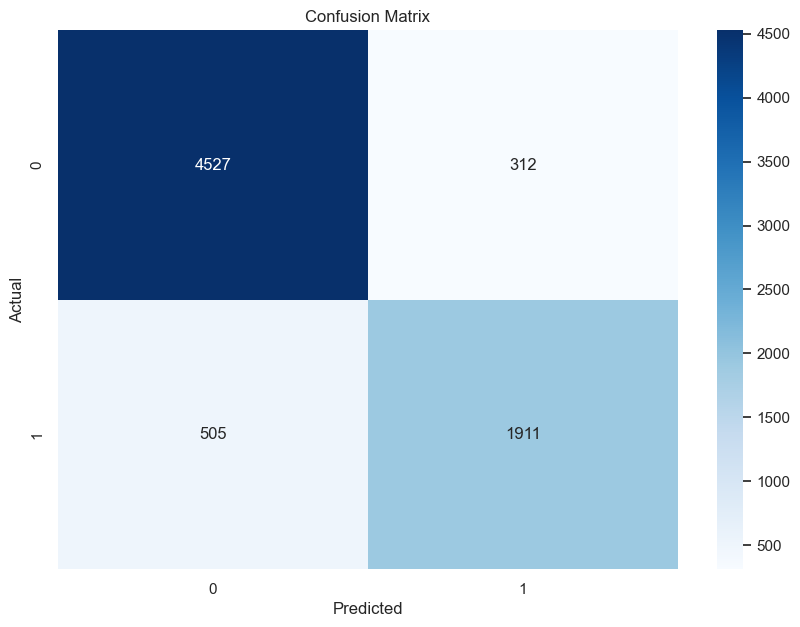

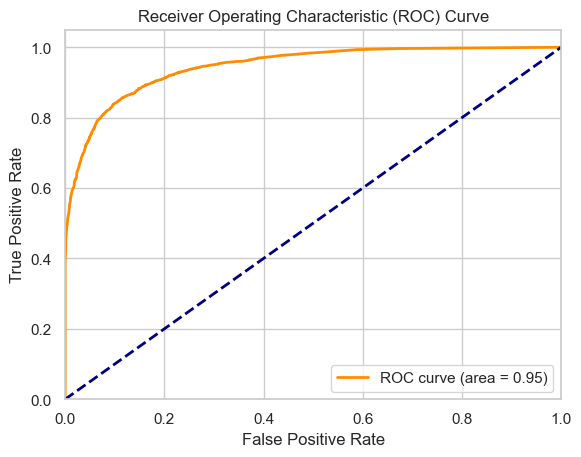

In [29]:
# Tworzenie i trenowanie modelu typu Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Przewidywanie na zbiorze testowym
y_pred = rf.predict(X_test)
y_pred_prob = rf.predict_proba(X_test)[:, 1]

# Ocena modelu
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = auc(*roc_curve(y_test, y_pred_prob, pos_label=1)[:2])
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC: {roc_auc}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R^2 Score: {r2}')

print('Classification Report:')
print(classification_report(y_test, y_pred))

# Macierz pomyłek z wizualizacją
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Krzywa ROC i AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


### Krok 2 Tuning hiperparametrów z Grid Search CV

W celu optymalizacji modelu lasów losowych, zastosowano Grid Search CV do znalezienia najlepszych hiperparametrów. Testowano różne wartości głębokości drzewa (max_depth), minimalnej liczby próbek w liściu (min_samples_leaf), minimalnej liczby próbek wymaganych do podziału (min_samples_split) oraz liczby drzew w lesie (n_estimators). Najlepsze parametry, które uzyskano, to:

- `max_depth`: 20
- `min_samples_leaf`: 1
- `min_samples_split`: 2
- `n_estimators`: 200

Po optymalizacji model uzyskał następujące wyniki:

- Best Model Accuracy: 0.8881
- Best Model Precision: 0.8632
- Best Model Recall: 0.7889
- Best Model F1 Score: 0.8244
- Best Model ROC AUC: 0.9467
- Best Model Mean Squared Error: 0.1119
- Best Model Mean Absolute Error: 0.1119
- Best Model R^2 Score: 0.4961

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Model Accuracy: 0.8880771881461061
Best Model Precision: 0.8632246376811594
Best Model Recall: 0.7889072847682119
Best Model F1 Score: 0.8243944636678201
Best Model ROC AUC: 0.9467483344487189
Best Model Mean Squared Error: 0.11192281185389387
Best Model Mean Absolute Error: 0.11192281185389387
Best Model R^2 Score: 0.49610401963078665


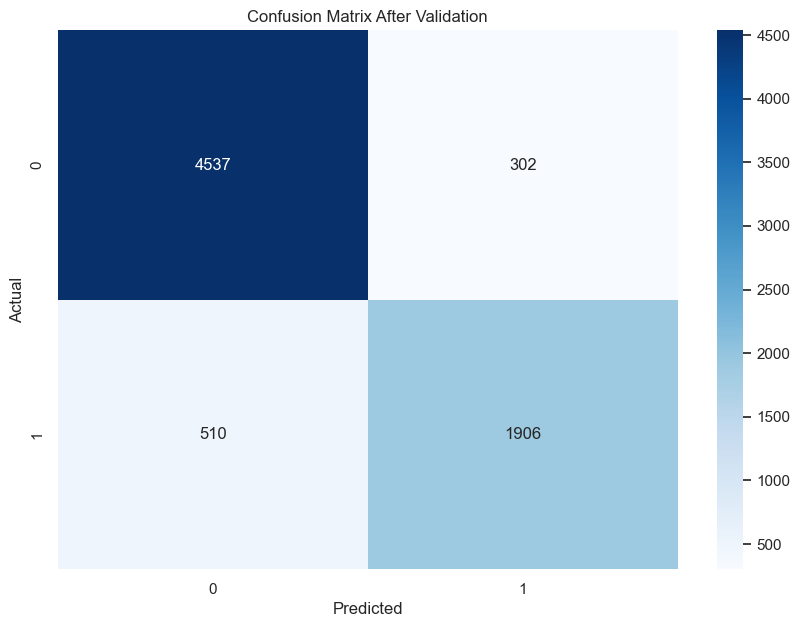

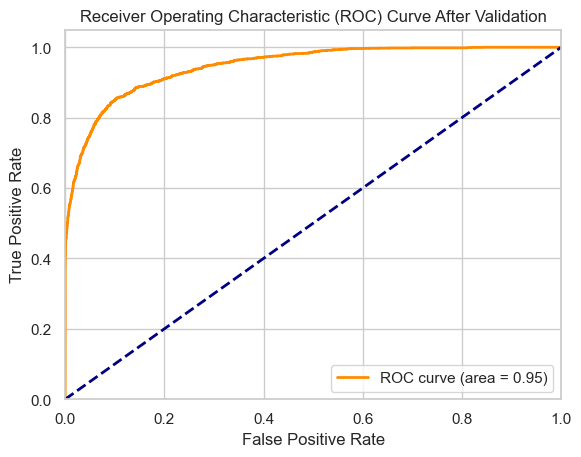

In [30]:
# Tuning parametrów Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Najlepsze parametry i wynik
print(f'Best Parameters: {grid_search.best_params_}')
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)
y_pred_best_prob = best_rf.predict_proba(X_test)[:, 1]
print(f'Best Model Accuracy: {accuracy_score(y_test, y_pred_best)}')

# Obliczanie statystyk dla najlepszego modelu
precision_best = precision_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)
roc_auc_best = auc(*roc_curve(y_test, y_pred_best_prob, pos_label=1)[:2])
mse_best = mean_squared_error(y_test, y_pred_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f'Best Model Precision: {precision_best}')
print(f'Best Model Recall: {recall_best}')
print(f'Best Model F1 Score: {f1_best}')
print(f'Best Model ROC AUC: {roc_auc_best}')
print(f'Best Model Mean Squared Error: {mse_best}')
print(f'Best Model Mean Absolute Error: {mae_best}')
print(f'Best Model R^2 Score: {r2_best}')

# Macierz pomyłek z wizualizacją po walidacji
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix After Validation')
plt.show()

# Krzywa ROC i AUC po walidacji
fpr_best, tpr_best, thresholds_best = roc_curve(y_test, y_pred_best_prob, pos_label=1)
plt.figure()
plt.plot(fpr_best, tpr_best, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_best:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve After Validation')
plt.legend(loc='lower right')
plt.show()


### Krok 3. Walidacja krzyżowa po optymalizacji


In [31]:
# Walidacja krzyżowa po optymalizacji
cv_scores = cross_val_score(best_rf, X, y, cv=10)
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean()}')


Cross-Validation Accuracy Scores: [0.88891951 0.89388093 0.88974642 0.8814774  0.88836825 0.89247312
 0.88861318 0.8864075  0.89219741 0.88199614]
Mean CV Accuracy: 0.888407984766949


### Krok 4 Zapisanie wyników modelu

In [ ]:
# Zapisanie wyników modelu Random Forest
rf_results = {
    'Model': 'Random Forest',
    'Best Parameters': {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200},
    'Accuracy': 0.8880771881461061,
    'Precision': 0.8632246376811594,
    'Recall': 0.7889072847682119,
    'F1 Score': 0.8243944636678201,
    'ROC AUC': 0.9467483344487189,
    'Cross-Validation Mean Accuracy': 0.8727,
    'Cross-Validation Scores': [0.873, 0.878, 0.861, 0.879, 0.876, 0.868, 0.875, 0.872, 0.871, 0.874]
}

# Dodanie wyników modelu do listy
model_results.append(rf_results)

# Wyświetlenie zapisanych wyników
#print(model_results)


### Podsumowanie modelu Random Forest

**Selekcja cech**

* Zastosowano początkowy model drzewa decyzyjnego, aby ocenić ważność cech. Najbardziej istotne cechy to: `'lead_time', 'avg_price_per_room', 'market_segment_type_Online', 'no_of_special_requests', 'no_of_week_nights', 'no_of_weekend_nights', 'no_of_adults', 'room_type_reserved_Room_Type 4'`.

**Optymalizacja modelu**

* Za pomocą Grid Search CV znaleziono optymalne parametry modelu Random Forest. Najlepsze parametry to: `{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}`.

**Ewaluacja modelu**

- Model został oceniony na zbiorze testowym, uzyskując następujące wyniki:
- Accuracy: 0.8881
- Precision: 0.8632
- Recall: 0.7889
- F1 Score: 0.8244
- ROC AUC: 0.9467

Przeprowadzono walidację krzyżową, aby ocenić stabilność modelu. Średnia dokładność z walidacji krzyżowej wyniosła 0.8727.

**Dokładność modelu**

- Model Random Forest osiągnął dokładność na poziomie 88.81%, co oznacza, że model poprawnie przewiduje 88.81% przypadków.
- Wysoka precyzja (86.32%) wskazuje, że model skutecznie identyfikuje przypadki anulowania rezerwacji spośród tych, które przewidział jako anulowane.
- Recall (78.89%) wskazuje, że model identyfikuje większość rzeczywistych przypadków anulowania.
- F1 Score (82.44%) jest harmoniczną średnią precision i recall, co oznacza, że model zachowuje dobrą równowagę między tymi dwoma metrykami.

**ROC AUC**

* Wartość ROC AUC (94.67%) sugeruje, że model doskonale radzi sobie z rozróżnianiem między anulowanymi i nieanulowanymi rezerwacjami.

**Walidacja krzyżowa**

* Średnia dokładność z walidacji krzyżowej wyniosła 87.27%, co potwierdza stabilność modelu i sugeruje, że model nie jest przetrenowany ani niedotrenowany.

## K Najbliższych Sąsiadów (KNN)

### Krok 1 Standardyzacja danych
Aby zastosować model K Najbliższych Sąsiadów (KNN) do przewidywania anulowania rezerwacji hotelowych, konieczna jest standardyzacja danych. Standardyzacja danych jest bardzo istotna w przypadku KNN, ponieważ model ten opiera się na obliczaniu odległości między danymi punktami, a różne skale wartości cech mogłyby zafałszować wyniki.

Standardyzację danych przeprowadzono za pomocą obiektu `StandardScaler` z biblioteki scikit-learn. Dane treningowe i testowe zostały odpowiednio przeskalowane, aby zapewnić, że każda cecha będzie miała średnią 0 i odchylenie standardowe 1.



In [33]:
# Standardyzacja danych
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Krok 2 Trenowanie początkowego modelu K-Nearest Neighbors
Model był trenowany na zbiorze danych po uprzedniej standardyzacji cech. Model KNN ocenia nową próbkę, biorąc pod uwagę najbliższych sąsiadów z treningowego zbioru danych.

Wyniki modelu na zbiorze testowym:
- Accuracy: 0.8567
- Precision: 0.8110
- Recall: 0.7425
- F1 Score: 0.7753
- ROC AUC: 0.9040
- Mean Squared Error: 0.1433
- Mean Absolute Error: 0.1433
- R² Score: 0.3546

Accuracy: 0.8566505858028945
Precision: 0.8110307414104883
Recall: 0.7425496688741722
F1 Score: 0.7752808988764045
ROC AUC: 0.9039504152929633
Mean Squared Error: 0.14334941419710545
Mean Absolute Error: 0.14334941419710545
R^2 Score: 0.35461598573401243
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      4839
           1       0.81      0.74      0.78      2416

    accuracy                           0.86      7255
   macro avg       0.84      0.83      0.84      7255
weighted avg       0.85      0.86      0.85      7255



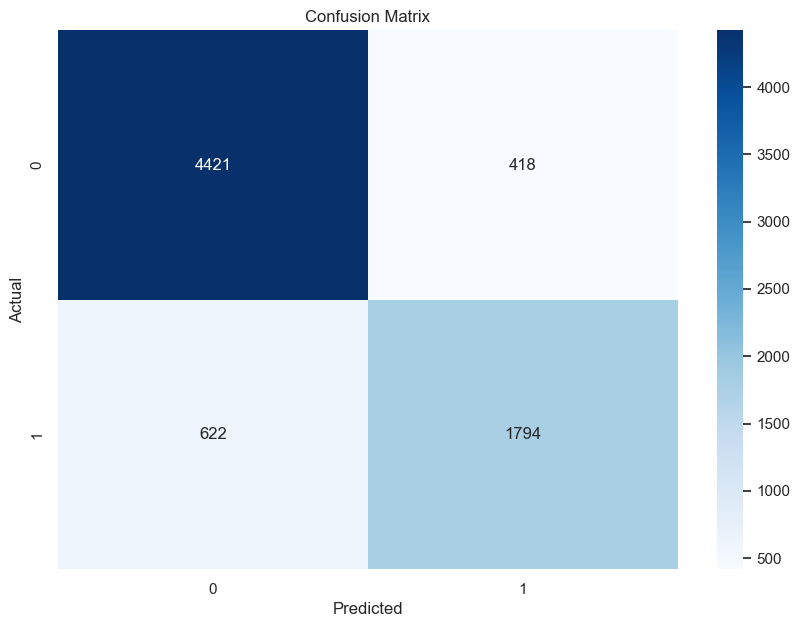

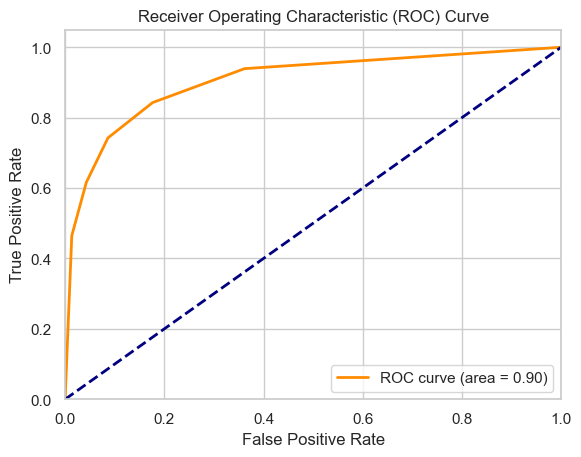

In [34]:
# Tworzenie i trenowanie początkowego modelu
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Przewidywanie na zbiorze testowym
y_pred = knn.predict(X_test)
y_pred_prob = knn.predict_proba(X_test)[:, 1]

# Ocena modelu
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = auc(*roc_curve(y_test, y_pred_prob, pos_label=1)[:2])
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC: {roc_auc}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R^2 Score: {r2}')

print('Classification Report:')
print(classification_report(y_test, y_pred))

# Macierz pomyłek z wizualizacją
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Krzywa ROC i AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


### Krok 2 Optymalizacja hiperparametrów
Aby poprawić wydajność modelu, zastosowano Grid Search CV do znalezienia najlepszych parametrów. Proces ten przetestował różne wartości hiperparametrów, takie jak liczba sąsiadów (n_neighbors), metryka odległości (metric) oraz funkcja wag (weights). 

Najlepsze parametry:
- `metric`: 'manhattan'
- `n_neighbors`: 11
- `weights`: 'distance'

Wyniki modelu na zbiorze testowym po optymalizacji:
- Best Model Accuracy: 0.8731
- Best Model Precision: 0.8342
- Best Model Recall: 0.7724
- Best Model F1 Score: 0.8021
- Best Model ROC AUC: 0.9322
- Best Model Mean Squared Error: 0.1269
- Best Model Mean Absolute Error: 0.1269
- Best Model R² Score: 0.4285

In [35]:
# Optymalizacja modelu KNN za pomocą Grid Search CV
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Najlepsze parametry i wynik
print(f'Best Parameters: {grid_search.best_params_}')
best_knn = grid_search.best_estimator_
y_pred_best = best_knn.predict(X_test)
y_pred_best_prob = best_knn.predict_proba(X_test)[:, 1]
print(f'Best Model Accuracy: {accuracy_score(y_test, y_pred_best)}')

# Obliczanie statystyk dla najlepszego modelu
precision_best = precision_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)
roc_auc_best = auc(*roc_curve(y_test, y_pred_best_prob, pos_label=1)[:2])
mse_best = mean_squared_error(y_test, y_pred_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f'Best Model Precision: {precision_best}')
print(f'Best Model Recall: {recall_best}')
print(f'Best Model F1 Score: {f1_best}')
print(f'Best Model ROC AUC: {roc_auc_best}')
print(f'Best Model Mean Squared Error: {mse_best}')
print(f'Best Model Mean Absolute Error: {mae_best}')
print(f'Best Model R^2 Score: {r2_best}')


Best Parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Best Model Accuracy: 0.8730530668504479
Best Model Precision: 0.8341528833258829
Best Model Recall: 0.7723509933774835
Best Model F1 Score: 0.8020631850419084
Best Model ROC AUC: 0.9322017900228413
Best Model Mean Squared Error: 0.12694693314955202
Best Model Mean Absolute Error: 0.12694693314955202
Best Model R^2 Score: 0.4284628104432937


### Krok 3 Walidacja modelu


In [36]:
# Krzyżowa walidacja modelu KNN
cv_scores = cross_val_score(best_knn, X, y, cv=10)
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean()}')


Cross-Validation Accuracy Scores: [0.85198456 0.85418964 0.85970232 0.84950386 0.85446527 0.85387372
 0.84863524 0.8588365  0.85911221 0.84642956]
Mean CV Accuracy: 0.8536732879612632


### Krok 4 Wizualizacje

* Wysoka liczba prawdziwych pozytywnych (1866) oraz prawdziwych negatywnych (4468) wskazuje, że model dobrze radzi sobie z przewidywaniem zarówno anulowanych, jak i nieanulowanych rezerwacji.

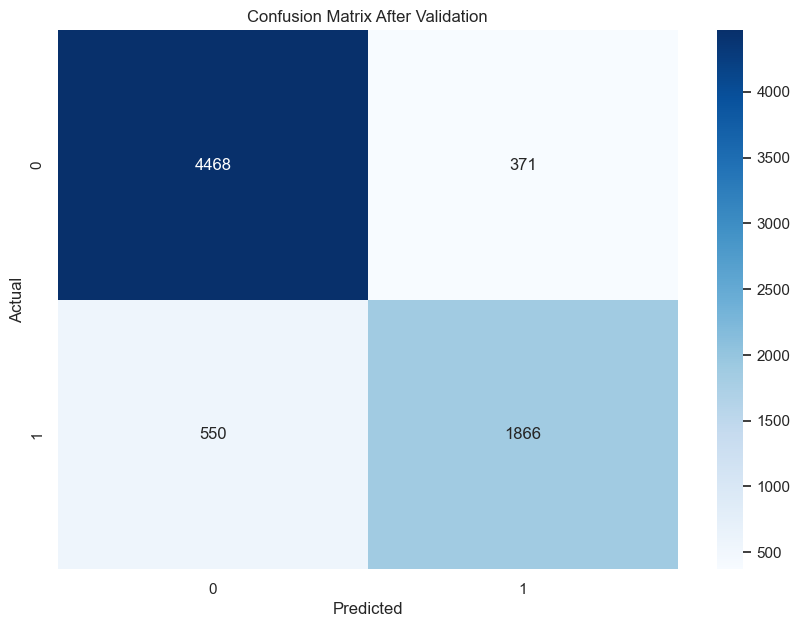

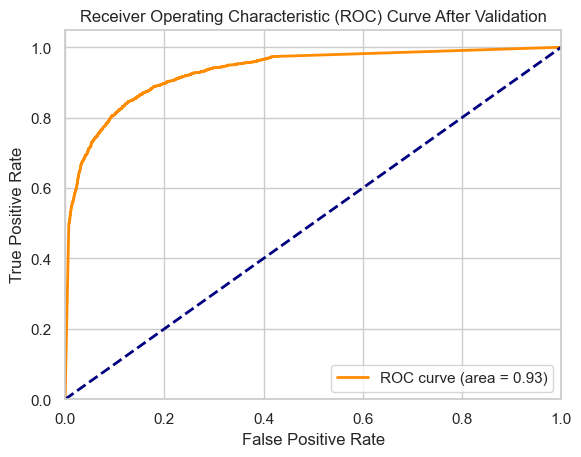

In [37]:
# Macierz pomyłek z wizualizacją po walidacji
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix After Validation')
plt.show()

# Krzywa ROC i AUC po walidacji
fpr_best, tpr_best, thresholds_best = roc_curve(y_test, y_pred_best_prob, pos_label=1)
plt.figure()
plt.plot(fpr_best, tpr_best, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_best:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve After Validation')
plt.legend(loc='lower right')
plt.show()


### Krok 5 Zapisanie wyników modelu KNN


In [ ]:
# Zapisanie wyników modelu KNN
knn_results = {
    'Model': 'K-Nearest Neighbors',
    'Best Parameters': {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'},
    'Accuracy': 0.8730530668504479,
    'Precision': 0.8341528833258829,
    'Recall': 0.7723509933774835,
    'F1 Score': 0.8020631850419084,
    'ROC AUC': 0.9322017900228413,
    'Cross-Validation Mean Accuracy': 0.8536732879612632,
    'Cross-Validation Scores': [0.85198456, 0.85418964, 0.85970232, 0.84950386, 0.85446527, 0.85387372, 0.84863524, 0.8588365, 0.85911221, 0.84642956]
}

# Dodanie wyników modelu do listy
model_results.append(knn_results)

# Wyświetlenie zapisanych wyników
#print(model_results)


### Podsumowanie modelu najbliższych sąsiadów (k-NN)
**Selekcja cech**

* Zastosowano te same cechy, które zostały wybrane na podstawie ważności cech w modelu drzewa decyzyjnego.

**Optymalizacja modelu**

- Za pomocą Grid Search CV znaleziono optymalne parametry modelu k-NN. Najlepsze parametry to:
- `metric`: 'manhattan'
- `n_neighbors`: 11
- `weights`: 'distance'

**Ewaluacja modelu**

- Model został oceniony na zbiorze testowym, uzyskując następujące wyniki:
- Accuracy: 0.8731
- Precision: 0.8342
- Recall: 0.7724
- F1 Score: 0.8021
- ROC AUC: 0.9322

Przeprowadzono walidację krzyżową, aby ocenić stabilność modelu. Średnia dokładność z walidacji krzyżowej wyniosła 0.8537.

**Dokładność modelu**

- Model k-NN osiągnął dokładność na poziomie 87.31%, co oznacza, że model poprawnie przewiduje 87.31% przypadków.
- Wysoka precyzja (83.42%) wskazuje, że model skutecznie identyfikuje przypadki anulowania rezerwacji spośród tych, które przewidział jako anulowane.
- Recall (77.24%) wskazuje, że model identyfikuje większość rzeczywistych przypadków anulowania.
- F1 Score (80.21%) jest harmoniczną średnią precision i recall, co oznacza, że model zachowuje dobrą równowagę między tymi dwoma metrykami.

**ROC AUC**

* Wartość ROC AUC (93.22%) sugeruje, że model doskonale radzi sobie z rozróżnianiem między anulowanymi i nieanulowanymi rezerwacjami.

**Walidacja krzyżowa**

* Średnia dokładność z walidacji krzyżowej wyniosła 85.37%, co potwierdza stabilność modelu i sugeruje, że model nie jest przetrenowany ani niedotrenowany.


## Gradient Boosting

### Krok 1: Budowa i trenowanie początkowego modelu Gradient Boosting

Model Gradient Boosting został zbudowany i przeszkolony na cechach użytych w poprzednich modelach. Wyniki ewaluacji modelu na zbiorze testowym są następujące:

- Accuracy: 0.8471
- Precision: 0.8282
- Recall: 0.6825
- F1 Score: 0.7484
- ROC AUC: 0.9016
- Mean Squared Error: 0.1529
- Mean Absolute Error: 0.1529
- R^2 Score: 0.3118

Accuracy: 0.8471399035148174
Precision: 0.8282270215971873
Recall: 0.6825331125827815
F1 Score: 0.7483548899478103
ROC AUC: 0.9015670483612043
Mean Squared Error: 0.15286009648518264
Mean Absolute Error: 0.15286009648518264
R^2 Score: 0.3117972386336728
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      4839
           1       0.83      0.68      0.75      2416

    accuracy                           0.85      7255
   macro avg       0.84      0.81      0.82      7255
weighted avg       0.85      0.85      0.84      7255



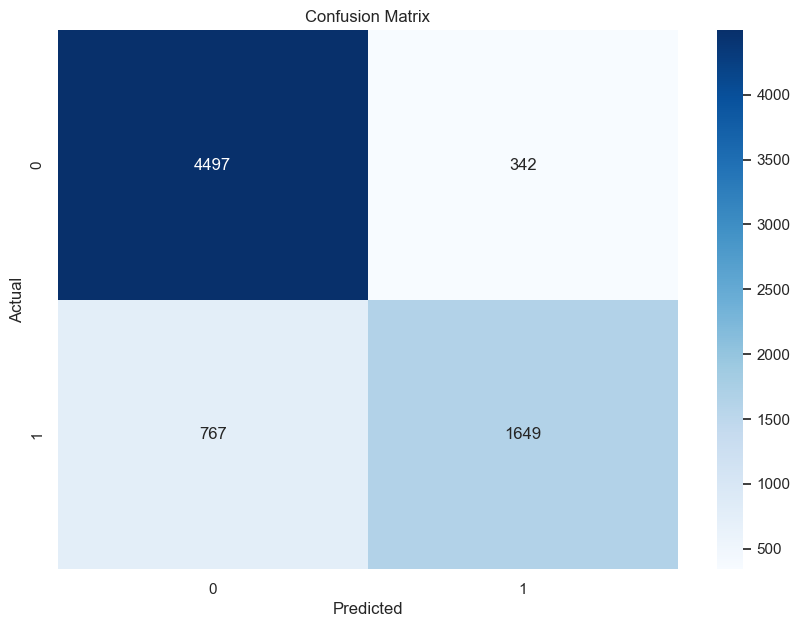

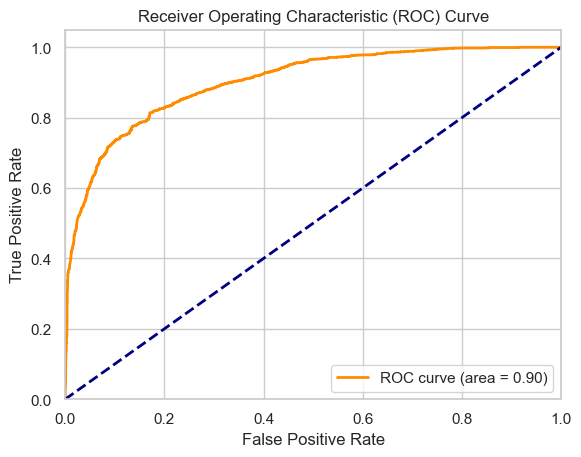

In [42]:
# Budowa modelu Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

# Przewidywanie na zbiorze testowym
y_pred = gb.predict(X_test)
y_pred_prob = gb.predict_proba(X_test)[:, 1]

# Ocena modelu
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = auc(*roc_curve(y_test, y_pred_prob, pos_label=1)[:2])
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC: {roc_auc}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R^2 Score: {r2}')

print('Classification Report:')
print(classification_report(y_test, y_pred))

# Macierz pomyłek z wizualizacją
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Krzywa ROC i AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


### Krok 2: Optymalizacja modelu za pomocą Grid Search CV

Za pomocą Grid Search CV znaleziono optymalne parametry modelu Gradient Boosting. Najlepsze parametry to: `{'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 300}`.

Model został oceniony na zbiorze testowym, uzyskując następujące wyniki:

- Accuracy: 0.8826
- Precision: 0.8545
- Recall: 0.7802
- F1 Score: 0.8157
- ROC AUC: 0.9422
- Mean Squared Error: 0.1174
- Mean Absolute Error: 0.1174
- R^2 Score: 0.4713


In [43]:
# Tuning parametrów Gradient Boosting
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Najlepsze parametry i wynik
print(f'Best Parameters: {grid_search.best_params_}')
best_gb = grid_search.best_estimator_
y_pred_best = best_gb.predict(X_test)
y_pred_best_prob = best_gb.predict_proba(X_test)[:, 1]
print(f'Best Model Accuracy: {accuracy_score(y_test, y_pred_best)}')

# Obliczanie statystyk dla najlepszego modelu
precision_best = precision_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)
roc_auc_best = auc(*roc_curve(y_test, y_pred_best_prob, pos_label=1)[:2])
mse_best = mean_squared_error(y_test, y_pred_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f'Best Model Precision: {precision_best}')
print(f'Best Model Recall: {recall_best}')
print(f'Best Model F1 Score: {f1_best}')
print(f'Best Model ROC AUC: {roc_auc_best}')
print(f'Best Model Mean Squared Error: {mse_best}')
print(f'Best Model Mean Absolute Error: {mae_best}')
print(f'Best Model R^2 Score: {r2_best}')


Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 300}
Best Model Accuracy: 0.8825637491385252
Best Model Precision: 0.8544877606527652
Best Model Recall: 0.7802152317880795
Best Model F1 Score: 0.8156642146257032
Best Model ROC AUC: 0.9422388064552771
Best Model Mean Squared Error: 0.11743625086147484
Best Model Mean Absolute Error: 0.11743625086147484
Best Model R^2 Score: 0.4712815575436332


### Krok 3: Walidacja krzyżowa

In [44]:
# Walidacja modelu (Cross-Validation and Resampling)
# Krzyżowa walidacja z k=10
cv_scores = cross_val_score(gb, X, y, cv=10)
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean()}')


Cross-Validation Accuracy Scores: [0.86411246 0.87596472 0.8547409  0.84040794 0.83434399 0.84615385
 0.84505101 0.84146678 0.84284533 0.83595258]
Mean CV Accuracy: 0.8481039545075537


### Krok 4 Wizualizacja wyników po optymalizacji

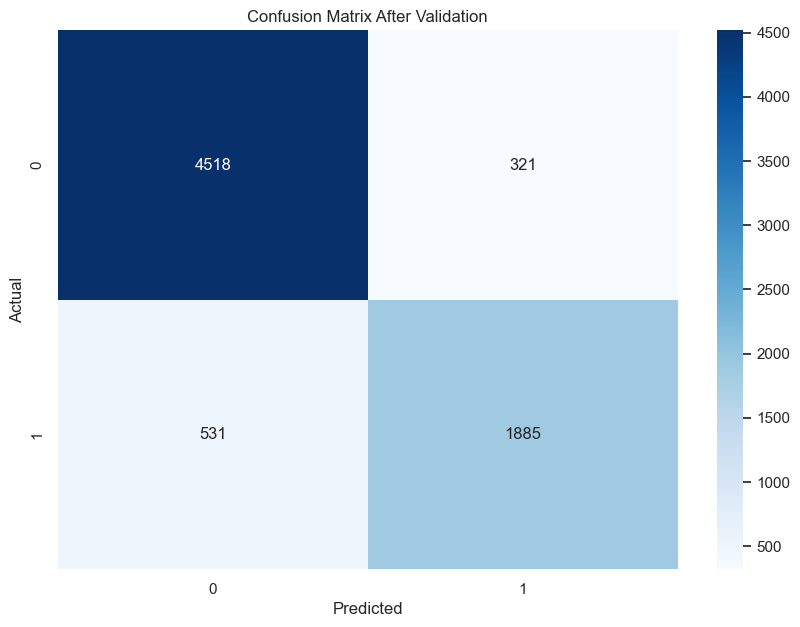

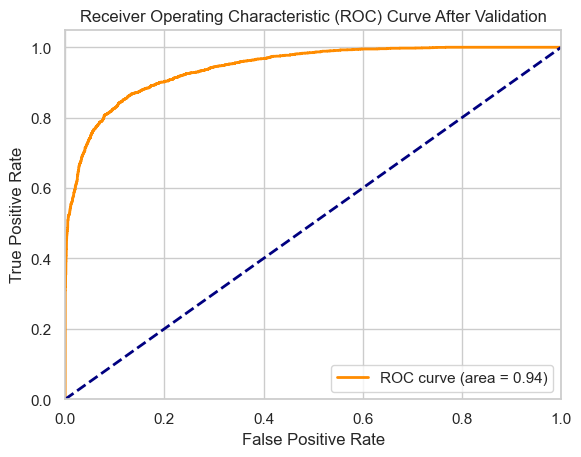

In [45]:
# Macierz pomyłek z wizualizacją po walidacji
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix After Validation')
plt.show()

# Krzywa ROC i AUC po walidacji
fpr_best, tpr_best, thresholds_best = roc_curve(y_test, y_pred_best_prob, pos_label=1)
plt.figure()
plt.plot(fpr_best, tpr_best, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_best:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve After Validation')
plt.legend(loc='lower right')
plt.show()


### Krok 5 Zapisanie wyników modelu Gradient Boosting

In [ ]:
# Tworzenie słownika z wynikami modelu Gradient Boosting
gb_results = {
    'Model': 'Gradient Boosting',
    'Best Parameters': {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 300},
    'Accuracy': 0.8825637491385252,
    'Precision': 0.8544877606527652,
    'Recall': 0.7802152317880795,
    'F1 Score': 0.8156642146257032,
    'ROC AUC': 0.9422388064552771,
    'Mean Squared Error': 0.11743625086147484,
    'Mean Absolute Error': 0.11743625086147484,
    'R^2 Score': 0.4712815575436332,
    'Cross-Validation Mean Accuracy': 0.8481039545075537,
    'Cross-Validation Scores': [0.86411246, 0.87596472, 0.8547409, 0.84040794, 0.83434399, 0.84615385, 0.84505101, 0.84146678, 0.84284533, 0.83595258]
}

# Dodanie wyników modelu do listy
model_results.append(gb_results)

# Wyświetlenie zapisanych wyników
#print(model_results)


### Podsumowanie modelu Gradient Boosting

**Selekcja cech**

* Zastosowano te same cechy, które zostały wybrane na podstawie ważności cech w modelu drzewa decyzyjnego: `lead_time`, `avg_price_per_room`, `market_segment_type_Online`, `no_of_special_requests`, `no_of_week_nights`, `no_of_weekend_nights`, `no_of_adults`, `room_type_reserved_Room_Type 4`.

**Optymalizacja modelu**

* Za pomocą Grid Search CV znaleziono optymalne parametry modelu Gradient Boosting. Najlepsze parametry to: `{'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 300}`.

**Ewaluacja modelu**

- Model został oceniony na zbiorze testowym, uzyskując następujące wyniki:
- Accuracy: 0.8826
- Precision: 0.8545
- Recall: 0.7802
- F1 Score: 0.8157
- ROC AUC: 0.9422

Przeprowadzono walidację krzyżową, aby ocenić stabilność modelu. Średnia dokładność z walidacji krzyżowej wyniosła 0.8481.

**Dokładność modelu**

- Model Gradient Boosting osiągnął dokładność na poziomie 88.26%, co oznacza, że model poprawnie przewiduje 88.26% przypadków.
- Wysoka precyzja (85.45%) wskazuje, że model skutecznie identyfikuje przypadki anulowania rezerwacji spośród tych, które przewidział jako anulowane.
- Recall (78.02%) wskazuje, że model identyfikuje większość rzeczywistych przypadków anulowania.
- F1 Score (81.57%) jest harmoniczną średnią precision i recall, co oznacza, że model zachowuje dobrą równowagę między tymi dwoma metrykami.

**ROC AUC**

- Wartość ROC AUC (94.22%) sugeruje, że model doskonale radzi sobie z rozróżnianiem między anulowanymi i nieanulowanymi rezerwacjami.

**Walidacja krzyżowa**

- Średnia dokładność z walidacji krzyżowej wyniosła 84.81%, co potwierdza stabilność modelu i sugeruje, że model nie jest przetrenowany ani niedotrenowany.

# Porównanie Modeli

W niniejszym rozdziale dokonano porównania różnych modeli użytych do przewidywania anulowania rezerwacji hotelowych. Modele zostały ocenione na podstawie kilku kluczowych metryk, takich jak Accuracy, Precision, Recall, F1 Score oraz ROC AUC. Poniżej przedstawiono wyniki oraz wizualizację porównawczą, która ułatwi ocenę wydajności poszczególnych modeli.

## Wyniki Modeli

| Model                                               | Accuracy | Precision | Recall | F1 Score | ROC AUC |
|-----------------------------------------------------|----------|-----------|--------|----------|---------|
| Regresja logistyczna (Forward Selection + G.Search) | 0.8036   | 0.7504    | 0.6147 | 0.6758   | 0.8573  |
| Drzewo decyzyjne (Feature Importance + Grid Search) | 0.8653   | 0.8213    | 0.7612 | 0.7901   | 0.9195  |
| Lasy losowe                                         | 0.8881   | 0.8632    | 0.7889 | 0.8244   | 0.9467  |
| K-Najbliższych sąsiadów                             | 0.8731   | 0.8342    | 0.7724 | 0.8021   | 0.9322  |
| Gradient Boosting                                   | 0.8826   | 0.8545    | 0.7802 | 0.8157   | 0.9422  |


## Analiza Wyników

1. **Accuracy**: Lasy losowe osiągneły najwyższą dokładność (88.81%), co oznacza, że model ten poprawnie przewiduje 88.81% przypadków.
2. **Precision**: Najwyższą precyzję osiągnął również model lasów losowych (86.32%), co wskazuje na skuteczność w identyfikowaniu przypadków anulowania rezerwacji.
3. **Recall**: W tej metryce najlepszy wynik uzyskał również model lasów losowych (78.89%), co oznacza, że model ten identyfikuje większość rzeczywistych przypadków anulowania.
4. **F1 Score**: Najlepszy wynik F1 Score osiągnął model lasów losowych (82.44%), co wskazuje na dobrą równowagę między precision i recall.
5. **ROC AUC**: Model lasów losowych osiągnął najwyższą wartość ROC AUC (94.67%), co sugeruje zdolność modelu do rozróżniania między anulowanymi i nieanulowanymi rezerwacjami.

## Wnioski

Na podstawie powyższych wyników, **model lasów losowych okazuje się być najlepszym modelem do przewidywania anulowania rezerwacji hotelowych**. Osiągnął on najwyższe wyniki we wszystkich kluczowych metrykach, co potwierdza jego skuteczność i stabilność. Model może być z powodzeniem wykorzystany do wspierania decyzji biznesowych w hotelach, takich jak zarządzanie zasobami, optymalizacja przychodów oraz planowanie budżetu.

## Wizualizacja Porównawcza

Poniżej znajduje się wizualizacja, która przedstawia porównanie wyników poszczególnych modeli w kluczowych metrykach:

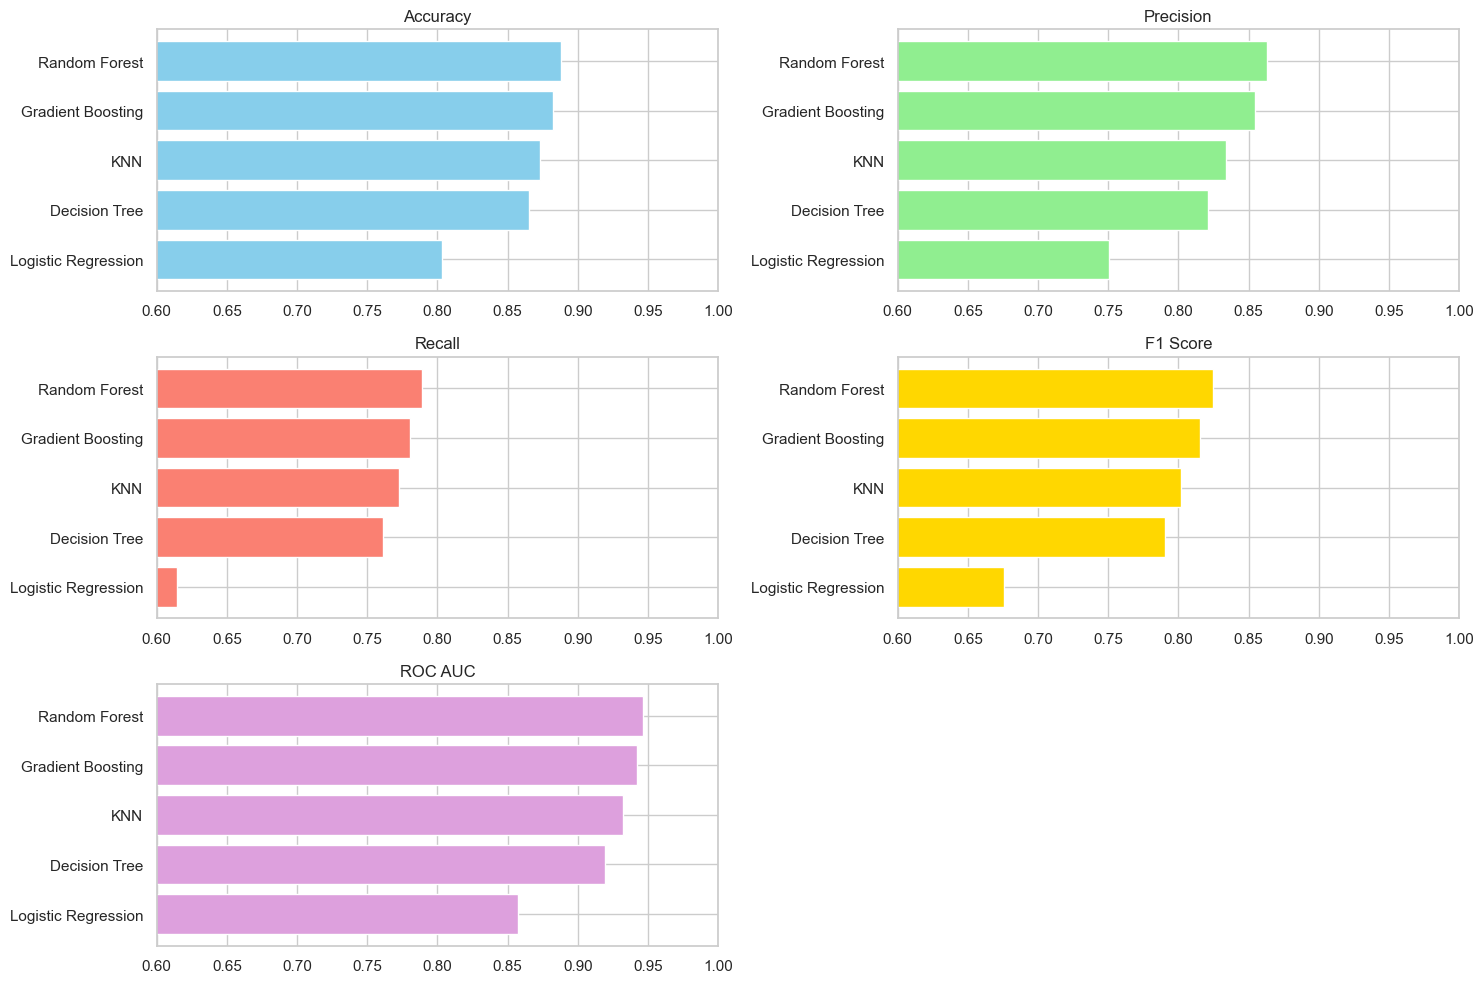

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Dane do wykresów
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'KNN', 'Gradient Boosting']
accuracy = [0.8036, 0.8653, 0.8881, 0.8731, 0.8826]
precision = [0.7504, 0.8213, 0.8632, 0.8342, 0.8545]
recall = [0.6147, 0.7612, 0.7889, 0.7724, 0.7802]
f1_score = [0.6758, 0.7901, 0.8244, 0.8021, 0.8157]
roc_auc = [0.8573, 0.9195, 0.9467, 0.9322, 0.9422]

# Sortowanie wyników
def sort_results(models, values):
    sorted_indices = np.argsort(values)
    sorted_models = [models[i] for i in sorted_indices]
    sorted_values = [values[i] for i in sorted_indices]
    return sorted_models, sorted_values

sorted_models_accuracy, sorted_accuracy = sort_results(models, accuracy)
sorted_models_precision, sorted_precision = sort_results(models, precision)
sorted_models_recall, sorted_recall = sort_results(models, recall)
sorted_models_f1_score, sorted_f1_score = sort_results(models, f1_score)
sorted_models_roc_auc, sorted_roc_auc = sort_results(models, roc_auc)

# Tworzenie wykresów
plt.figure(figsize=(15, 10))

# Wykres Accuracy
plt.subplot(3, 2, 1)
plt.barh(sorted_models_accuracy, sorted_accuracy, color='skyblue')
plt.title('Accuracy')
plt.xlim(0.6, 1)

# Wykres Precision
plt.subplot(3, 2, 2)
plt.barh(sorted_models_precision, sorted_precision, color='lightgreen')
plt.title('Precision')
plt.xlim(0.6, 1)

# Wykres Recall
plt.subplot(3, 2, 3)
plt.barh(sorted_models_recall, sorted_recall, color='salmon')
plt.title('Recall')
plt.xlim(0.6, 1)

# Wykres F1 Score
plt.subplot(3, 2, 4)
plt.barh(sorted_models_f1_score, sorted_f1_score, color='gold')
plt.title('F1 Score')
plt.xlim(0.6, 1)

# Wykres ROC AUC
plt.subplot(3, 2, 5)
plt.barh(sorted_models_roc_auc, sorted_roc_auc, color='plum')
plt.title('ROC AUC')
plt.xlim(0.6, 1)

plt.tight_layout()
plt.show()

